# Chapter 10
## Building Univariate Time Series Models Using Statistical Methods


# ---START: Technical Requirements---


In [1]:
#!pip install pandas statsmodels matplotlib scikit-learn
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib 
import scipy 
import sklearn
import statsmodels
import numpy
import pandas

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pandas.__version__}   
numpy -> {numpy.__version__}
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
sklearn -> {sklearn.__version__}
''')


Matplotlib -> 3.10.6
pandas -> 2.3.3   
numpy -> 1.26.4
scipy -> 1.15.3
statsmodels -> 0.14.5
sklearn -> 1.7.2



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Time series analysis tools
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model evaluation metrics
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

# Utility functions
from pathlib import Path

# warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  
plt.style.use('grayscale')


In [4]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [5]:
# Define file paths for the datasets
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [6]:
life.shape

(59, 1)

In [7]:
milk.shape

(168, 1)

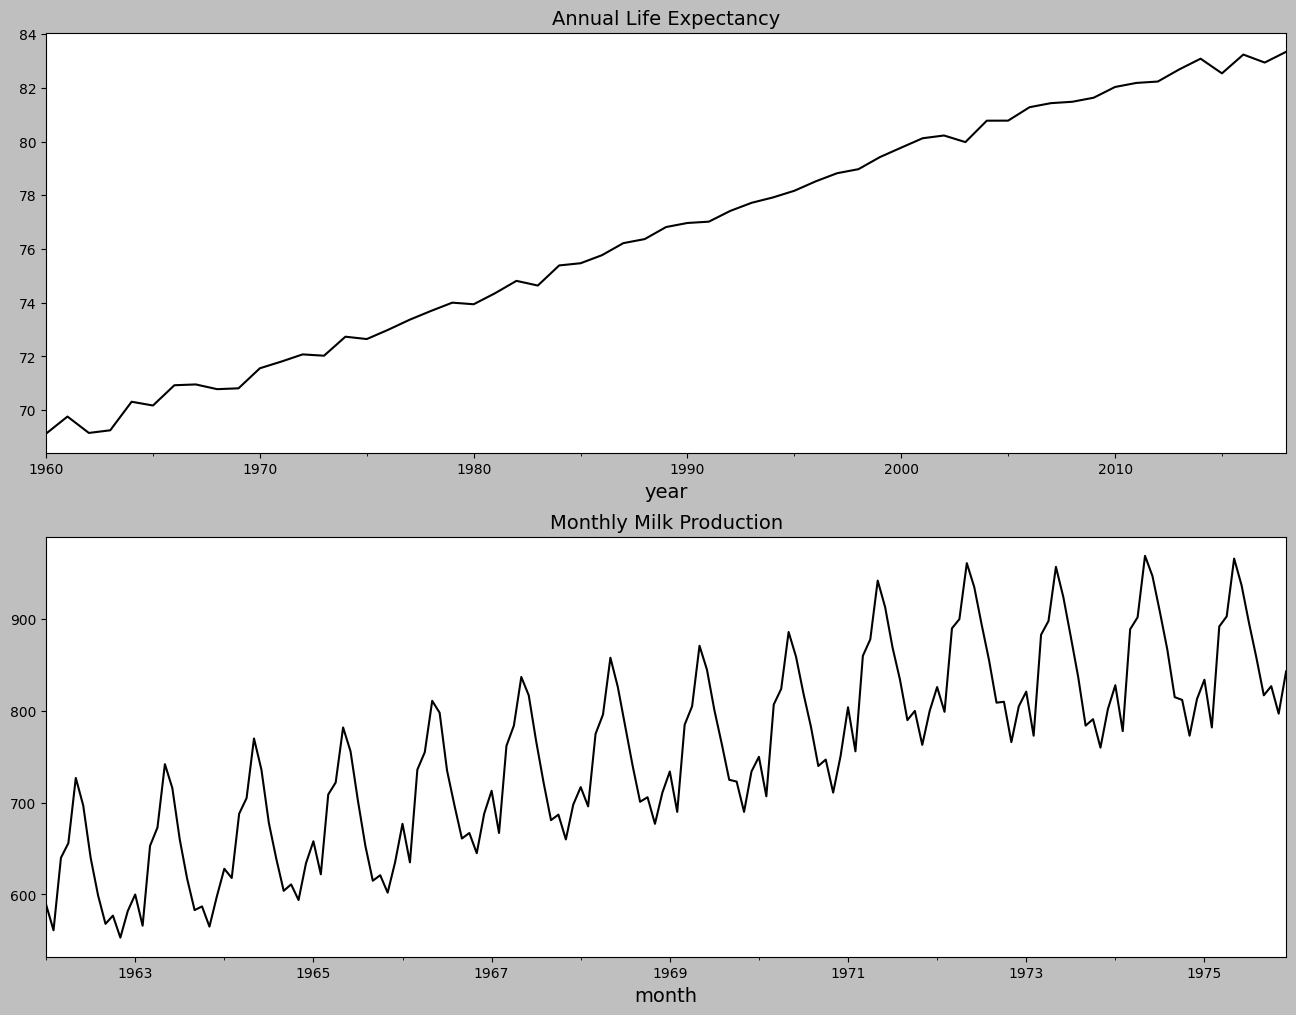

In [8]:
# Create subplots for visual comparison of both time series
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]);

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [9]:
from utils import split_data, check_stationarity, get_top_models_df, plot_forecast, combinator


In [10]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


# Recipe 1. Plotting ACF and PACF

<Axes: xlabel='year'>

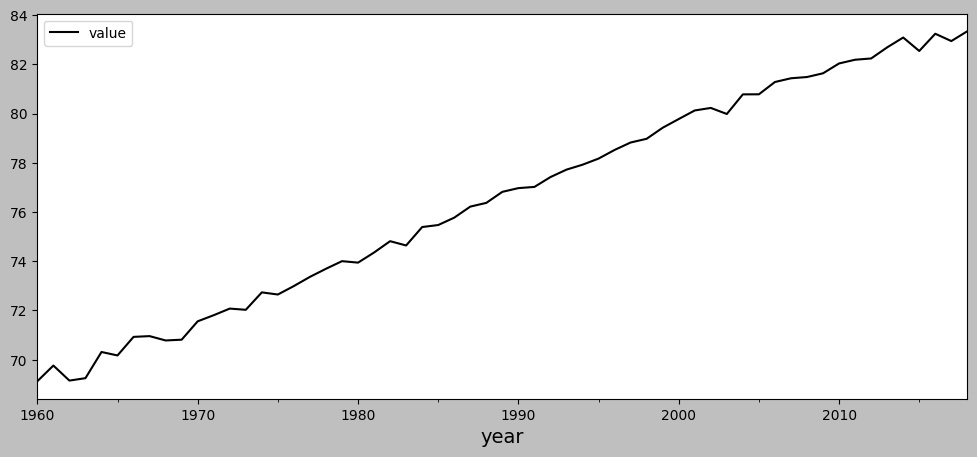

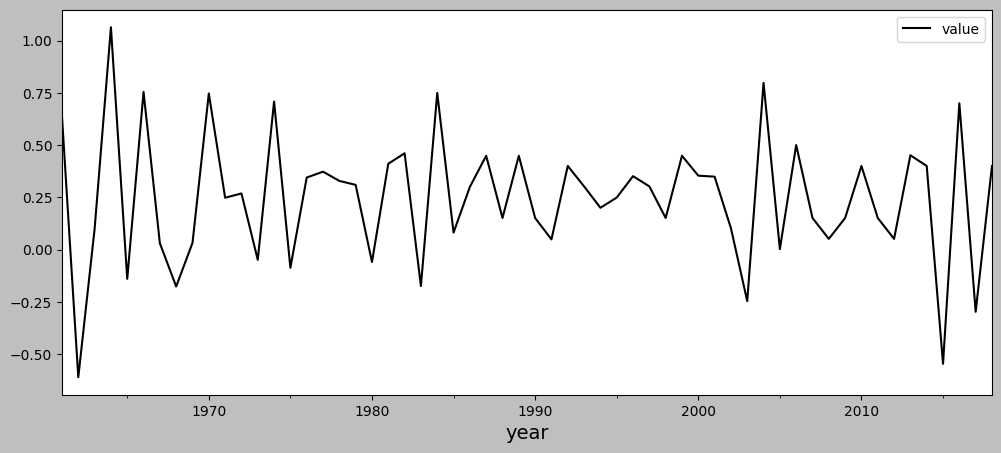

In [11]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [12]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800034 	 lags:2


('Non-Stationary', np.float64(0.6420882853800034))

In [13]:
check_stationarity(life_diff)

'Stationary	 p-value:1.5562189676003074e-14 	 lags:1


('Stationary', np.float64(1.5562189676003074e-14))

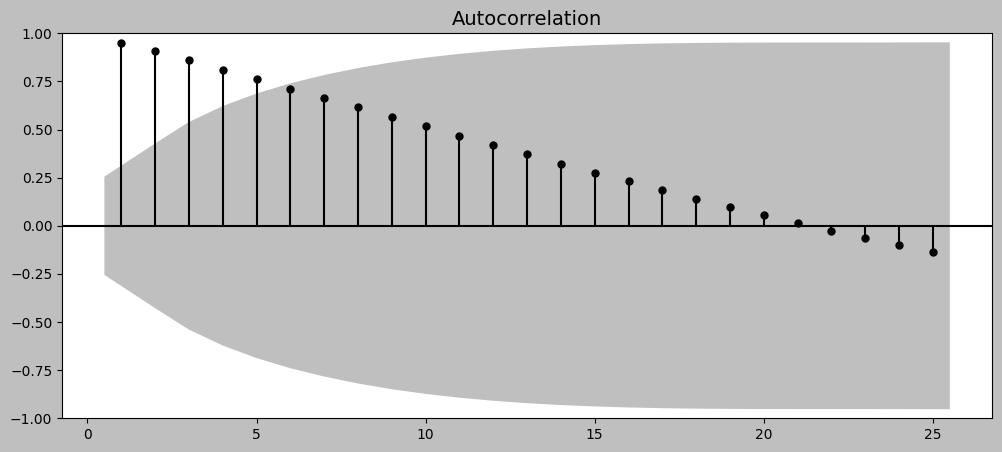

In [14]:
plot_acf(life, lags=25,zero=False);

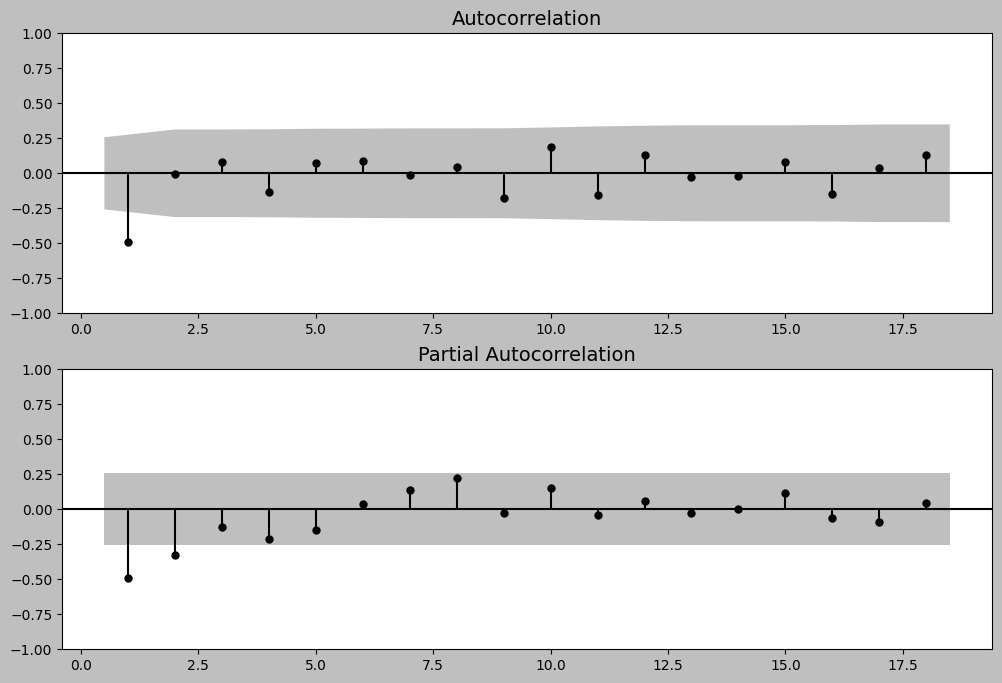

In [15]:
# Calculate first differences and remove any NA values
fig, ax = plt.subplots(2,1, figsize=(12,8))

# Create subplots for both ACF and PACF
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1]);
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)

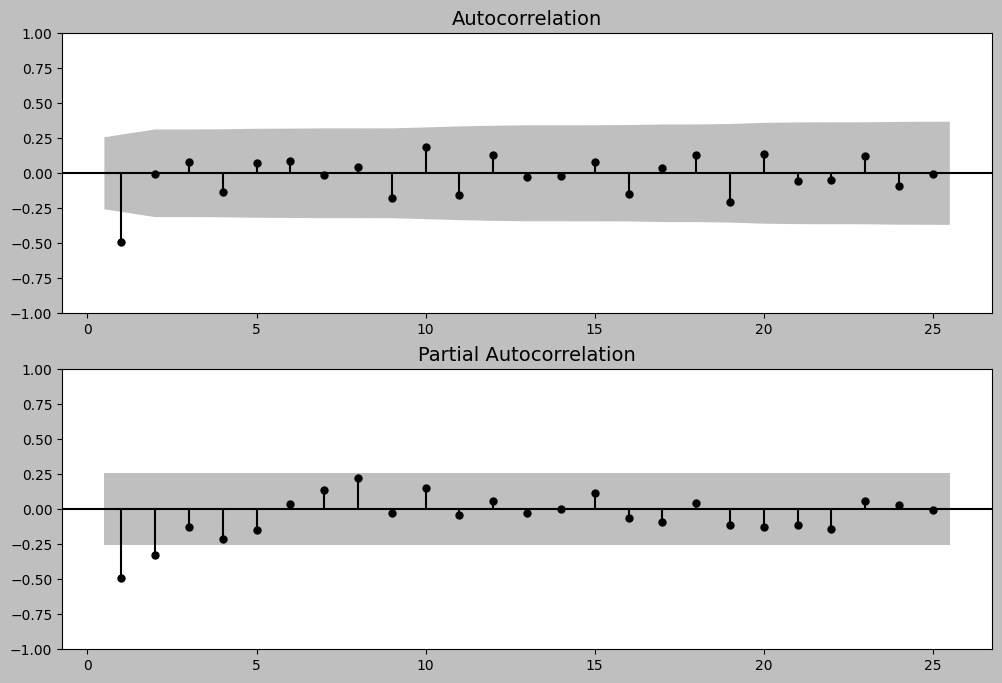

In [16]:
# increase number of lags
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, lags=25, zero=False, ax=ax[0])
plot_pacf(life_diff, lags=25,  zero=False, ax=ax[1]);

<Axes: xlabel='month'>

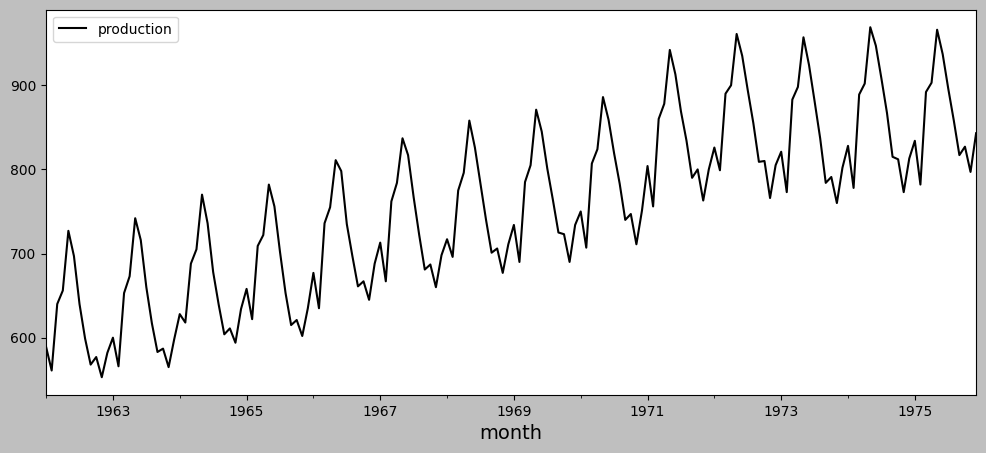

In [17]:
milk.plot()

<Axes: xlabel='month'>

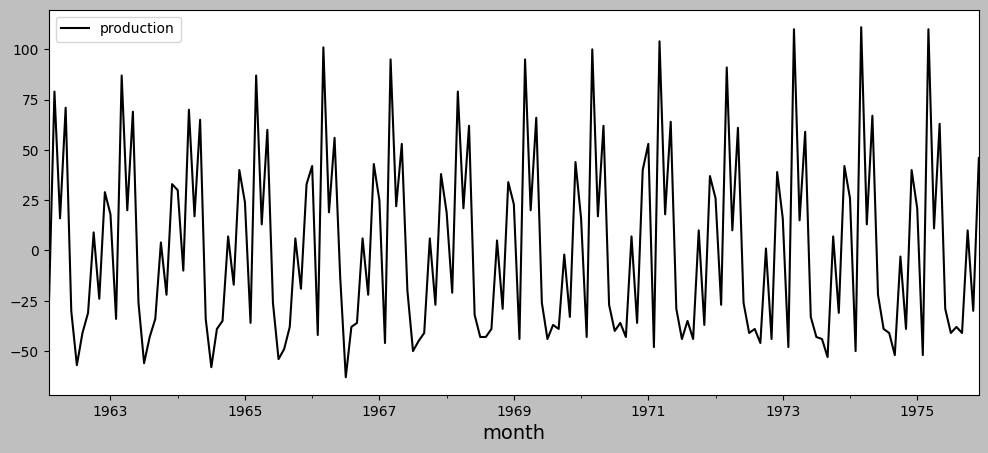

In [18]:
milk.diff().dropna().plot()

<Axes: xlabel='month'>

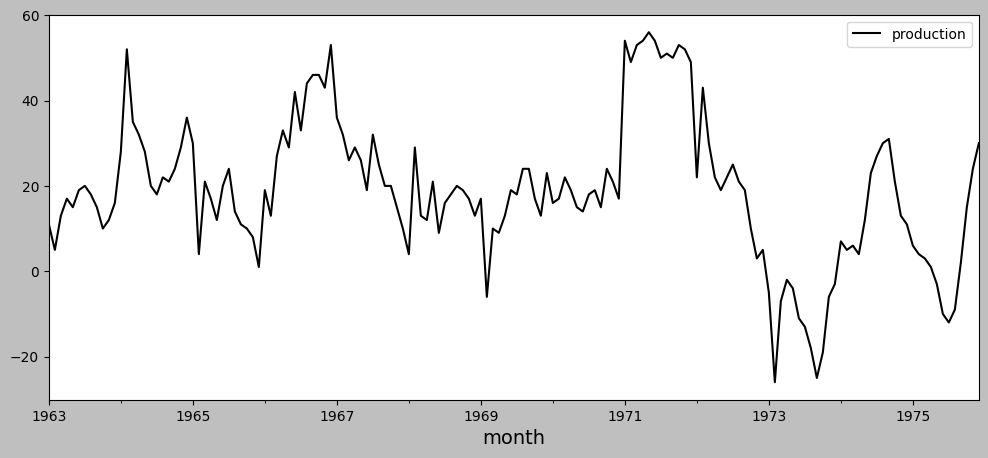

In [19]:
milk.diff(12).dropna().plot()

<Axes: xlabel='month'>

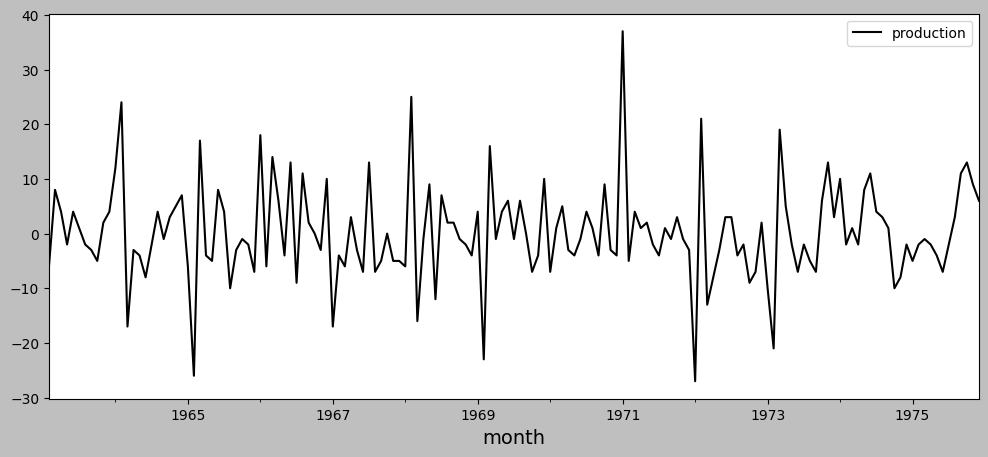

In [20]:
milk.diff(12).diff().dropna().plot()

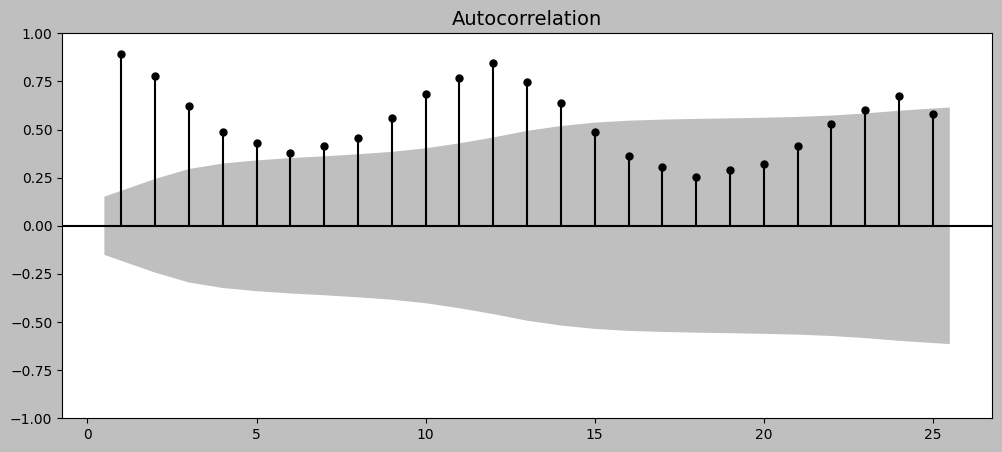

In [21]:
plot_acf(milk, lags=25,zero=False, alpha=0.05);

In [22]:
milk_diff_12 = milk.diff(12).dropna()

In [23]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711304 	 lags:12


('Non-Stationary', np.float64(0.16079880527711304))

In [24]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.8654234318789037e-05 	 lags:11


('Stationary', np.float64(1.8654234318789037e-05))

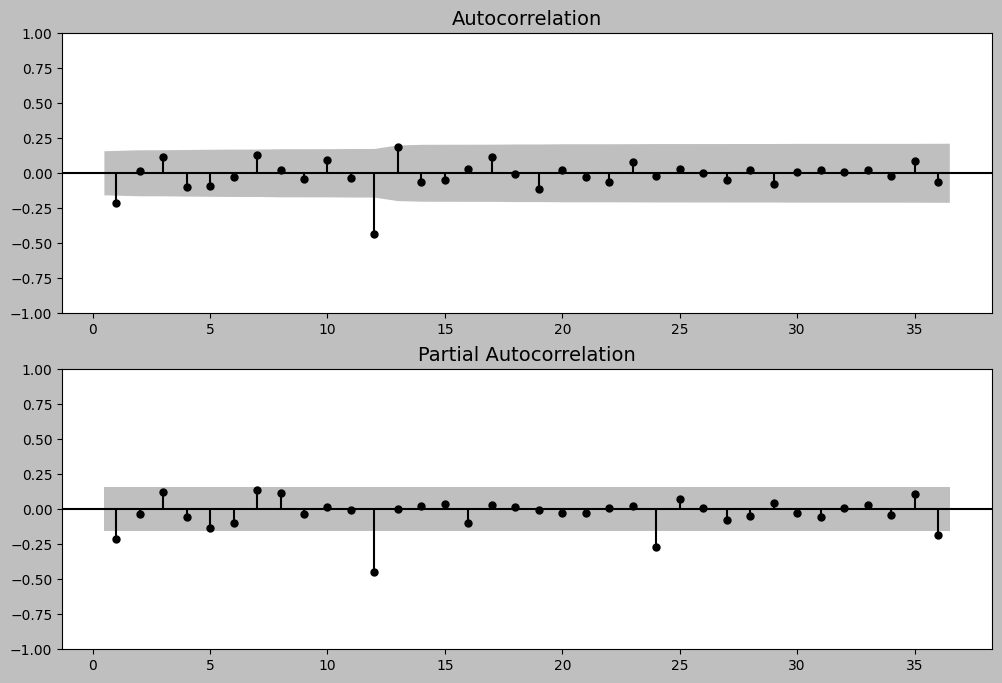

In [25]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

## There is more

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12),
               freq='MS').fit(disp=False)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


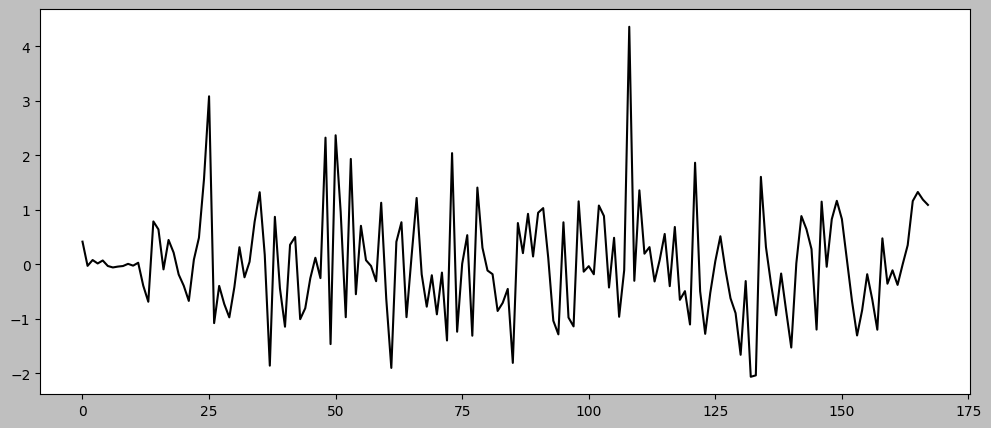

In [27]:
plt.plot(model.filter_results.standardized_forecasts_error[0]);

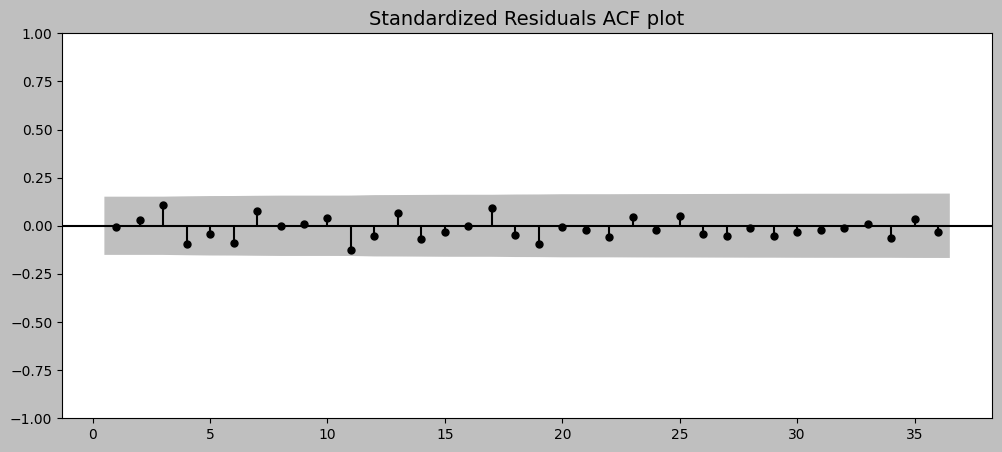

In [28]:
standardized_resid = model.filter_results.standardized_forecasts_error[0]
plot_acf(standardized_resid, 
         zero=False, 
         lags=36, 
         title='Standardized Residuals ACF plot');

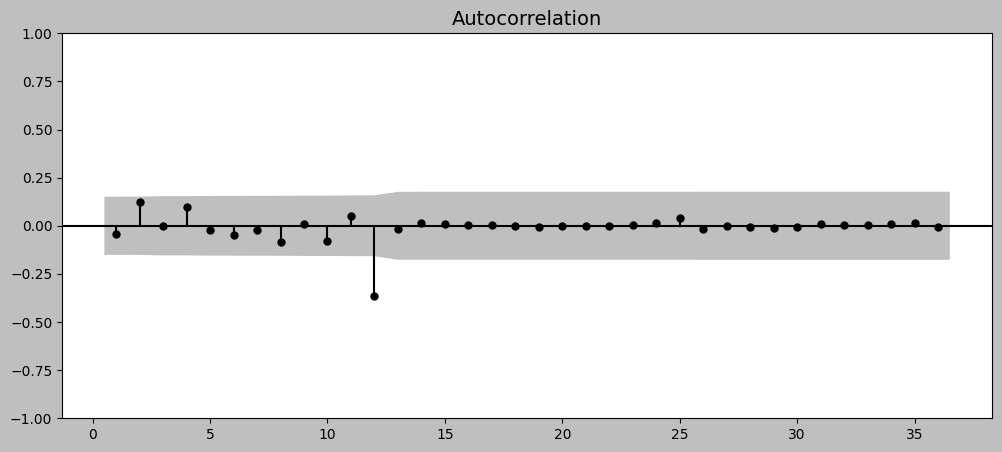

In [29]:
plot_acf(model.resid, zero=False, lags=36);

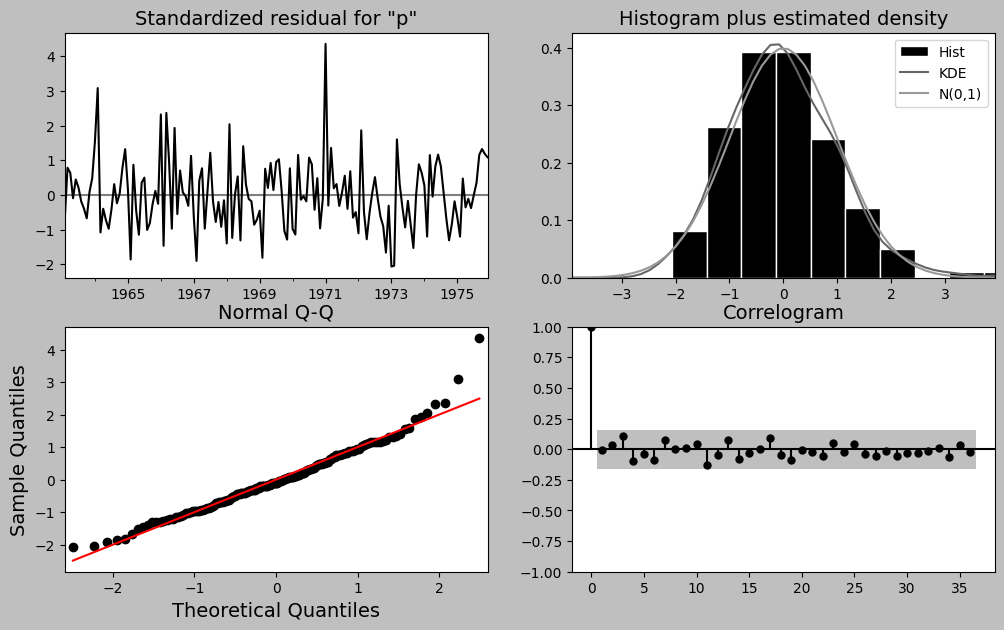

In [30]:
model.plot_diagnostics(figsize=(12,7), lags=36);

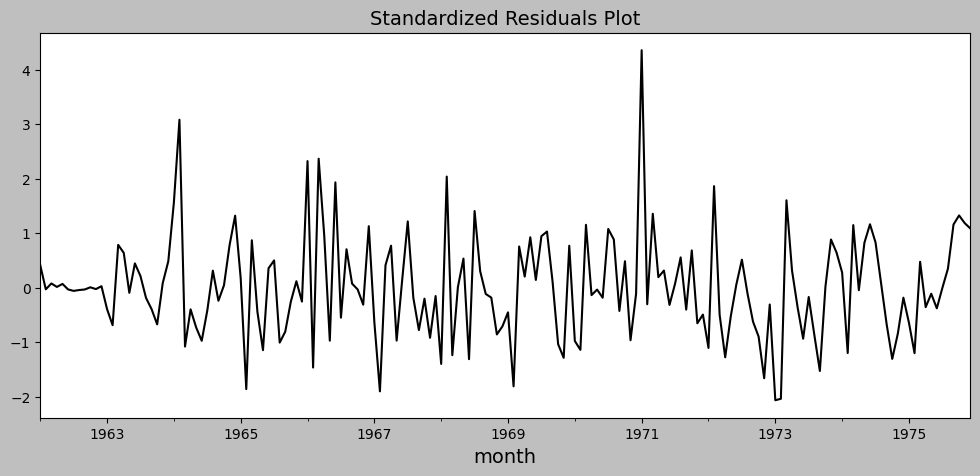

In [31]:
pd.DataFrame(model.standardized_forecasts_error.ravel(), 
             index=milk.index).plot(title='Standardized Residuals Plot', 
                                    legend=False);

# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [32]:
from statsmodels.tsa.api import ExponentialSmoothing

In [33]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
print(life_ex_comb)

[('add', True), ('add', False), ('mul', True), ('mul', False)]


In [34]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [35]:
model_eval = get_top_models_df(score)
model_eval

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
1,add,False,-137.030604,-129.382512,-135.077115,0.067753,0.561541,0.005570,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,mul,False,-136.344215,-128.696123,-134.390727,0.070527,0.584578,0.005835,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,mul,True,-134.829825,-125.269710,-132.163159,0.064569,0.535100,0.005268,<statsmodels.tsa.holtwinters.results.HoltWinte...
0,add,True,-133.771862,-124.211747,-131.105195,0.051096,0.423379,0.003974,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [36]:
get_top_models_df(score, criterion='BIC', top_n=3)

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
1,add,False,-137.030604,-129.382512,-135.077115,0.067753,0.561541,0.005570,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,mul,False,-136.344215,-128.696123,-134.390727,0.070527,0.584578,0.005835,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,mul,True,-134.829825,-125.269710,-132.163159,0.064569,0.535100,0.005268,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [37]:
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
1,add,False,-137.030604,-129.382512,-135.077115,0.067753,0.561541,0.005570
3,mul,False,-136.344215,-128.696123,-134.390727,0.070527,0.584578,0.005835
2,mul,True,-134.829825,-125.269710,-132.163159,0.064569,0.535100,0.005268
0,add,True,-133.771862,-124.211747,-131.105195,0.051096,0.423379,0.003974


In [38]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Thu, 04 Dec 2025"
Box-Cox:,False,Time:,12:54:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621215,alpha,True
smoothing_trend,0.1621215,beta,True


In [39]:
top_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162122,True
smoothing_trend,beta,0.162122,True
initial_level,l.0,68.748321,True
initial_trend,b.0,0.242256,True


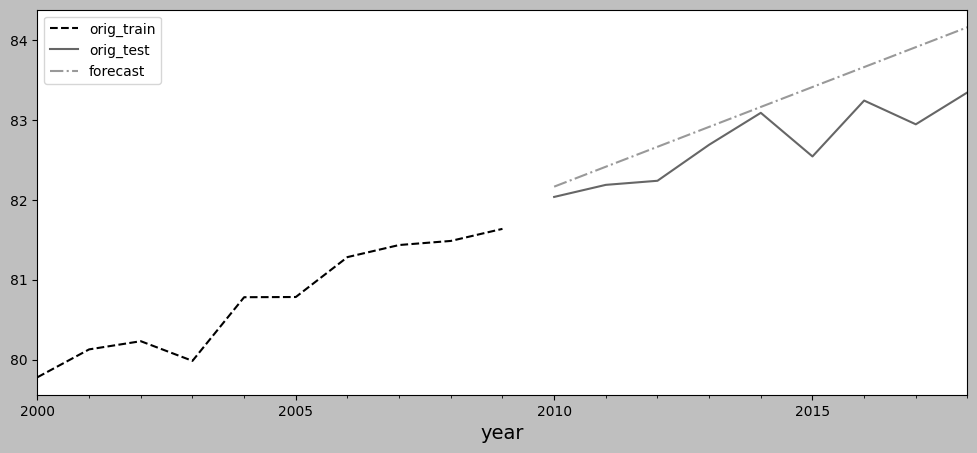

In [40]:
plot_forecast(top_model, '2000', life_train, life_test);

In [41]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [42]:
len(milk_exp_comb)

24

In [43]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [44]:
model_eval = get_top_models_df(score, 'AIC', top_n=5)
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
8,add,False,593.713882,641.119396,599.230011,0.148817,12.769731,0.011725
20,mul,False,594.758581,642.164095,600.274710,0.175151,15.049807,0.014274
2,add,True,595.562717,645.931075,601.741579,0.129827,11.036820,0.010305
11,add,False,614.894416,662.299930,620.410545,0.220576,19.858487,0.017101
23,mul,False,615.504756,662.910271,621.020886,0.246720,22.160203,0.019684


In [45]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 04 Dec 2025"
Box-Cox:,False,Time:,12:54:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859931,alpha,True
smoothing_trend,0.000000,beta,True


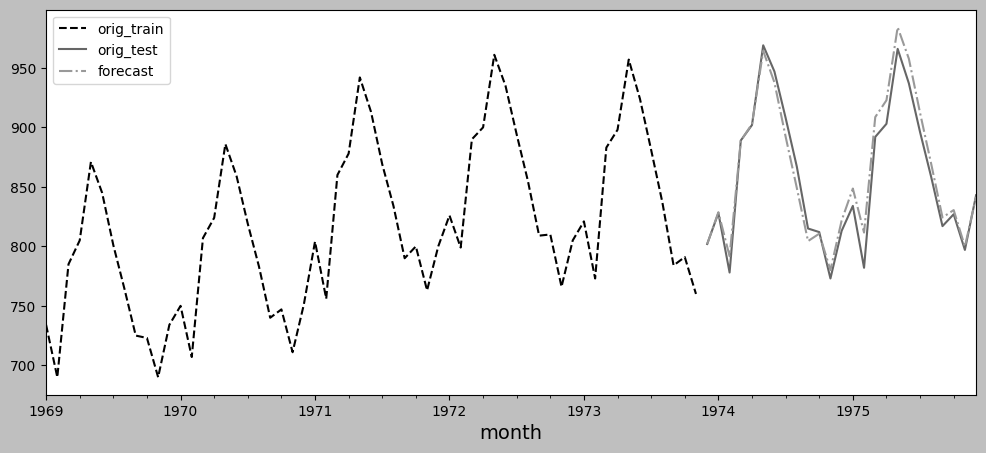

In [46]:
plot_forecast(top_model, '1969', milk_train, milk_test);

## There is more

In [47]:
import darts
darts.__version__

'0.38.0'

In [48]:
from darts.models import ExponentialSmoothing, AutoETS
from darts import TimeSeries

The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [49]:
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                               time_col='month', 
                               value_cols='production', 
                               freq='MS')

In [50]:
type(ts)

darts.timeseries.TimeSeries

### Darts ExponentialSmoothing

In [51]:
# exponential smoothing
model = ExponentialSmoothing(seasonal_periods=12)

train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [52]:
model

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12, error=add, random_errors=None, random_state=None, kwargs=None)

In [53]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

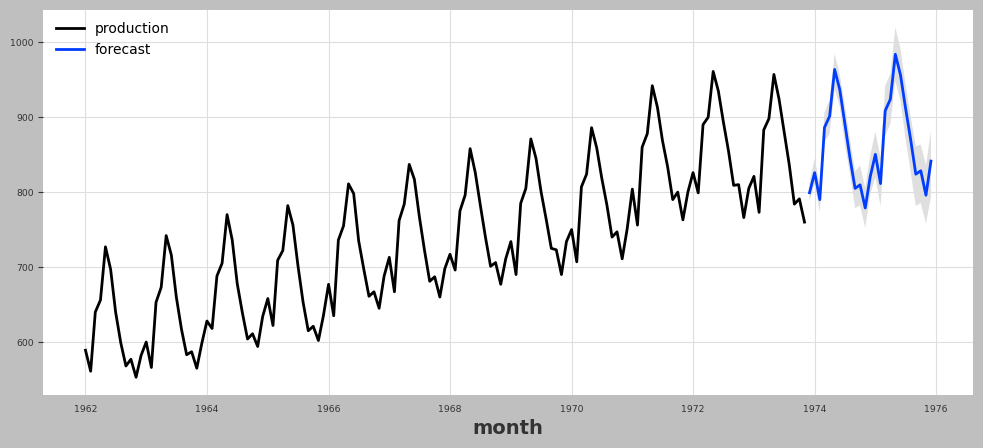

In [54]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95, default_formatting=False);
# plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

In [55]:
#exponential smoothing
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 04 Dec 2025"
Box-Cox:,False,Time:,12:55:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859931,alpha,True
smoothing_trend,0.000000,beta,True


### Darts AutoETS

In [56]:
# StatsForecast AutoETS
model_ets = AutoETS(season_length=12)
model_ets.fit(train)

AutoETS(add_encoders=None, quantiles=None, random_state=None, season_length=12)

In [57]:
ets_forecast = model_ets.predict(len(test), num_samples=100)

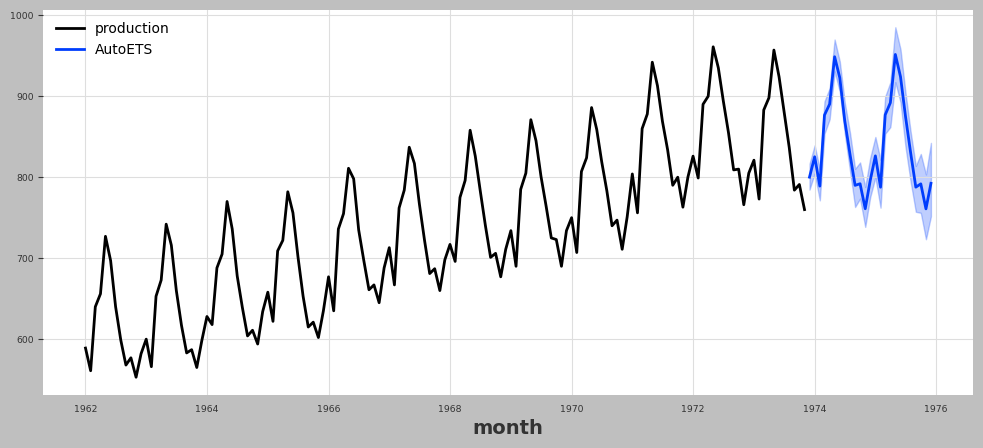

In [58]:
train.plot()
ets_forecast.plot(label='AutoETS');

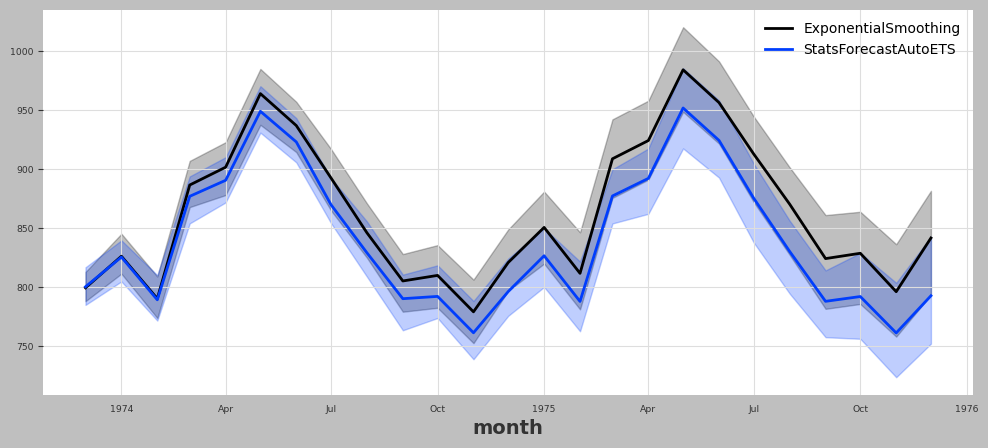

In [59]:
forecast.plot(label='ExponentialSmoothing')
ets_forecast.plot(label='StatsForecastAutoETS');

In [60]:
#modelets.model.model_

# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [61]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

In [62]:
life.index

DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

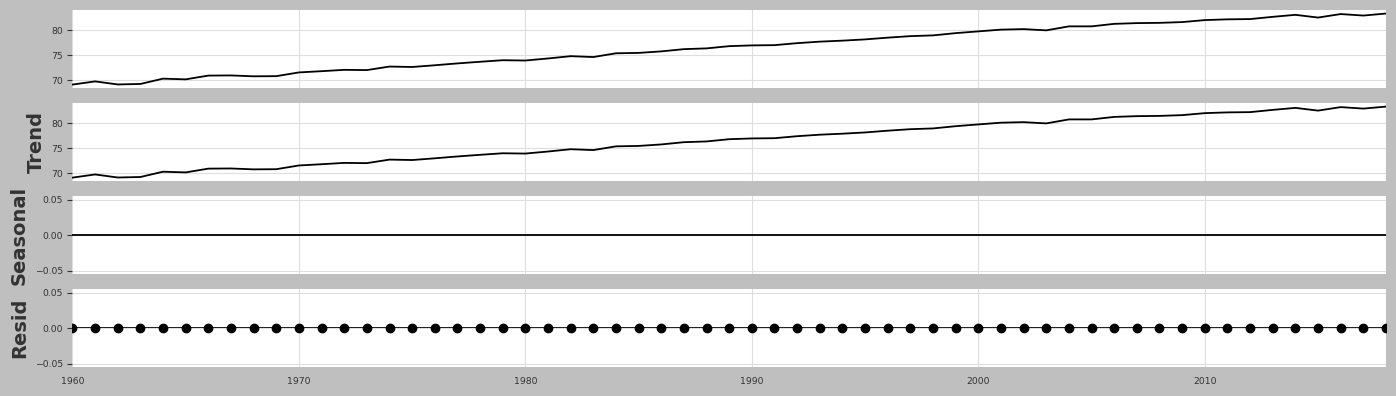

In [63]:
decomposed = seasonal_decompose(life)
decomposed.plot();
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)

In [64]:
# plt.rcParams["figure.figsize"] = [14, 6]  
# decomposed = seasonal_decompose(milk, period=12)
# decomposed.plot();

In [65]:
from pandas.plotting import autocorrelation_plot

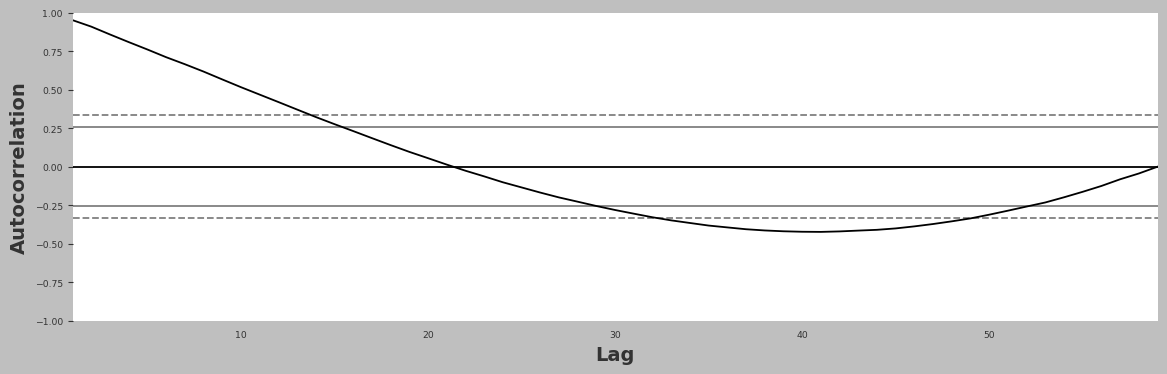

In [66]:
autocorrelation_plot(life);

In [67]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800034 	 lags:2


('Non-Stationary', np.float64(0.6420882853800034))

In [68]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676003074e-14 	 lags:1


('Stationary', np.float64(1.5562189676003074e-14))

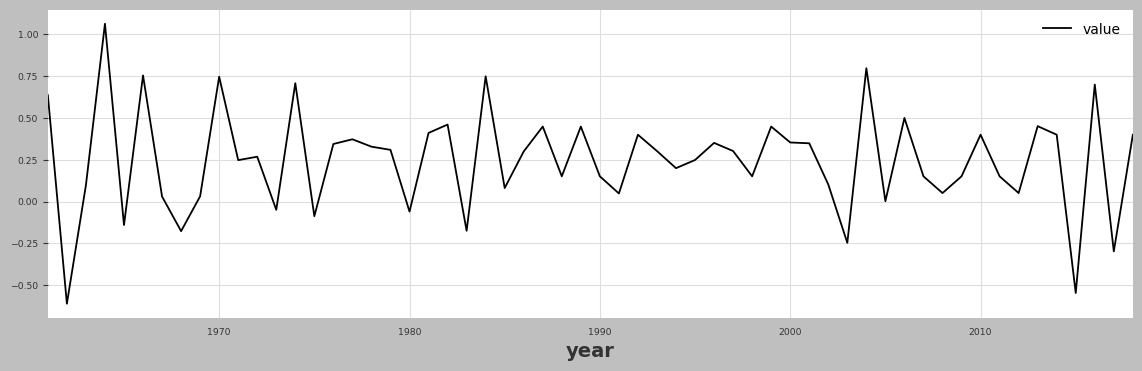

In [69]:
life_df1.plot();
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

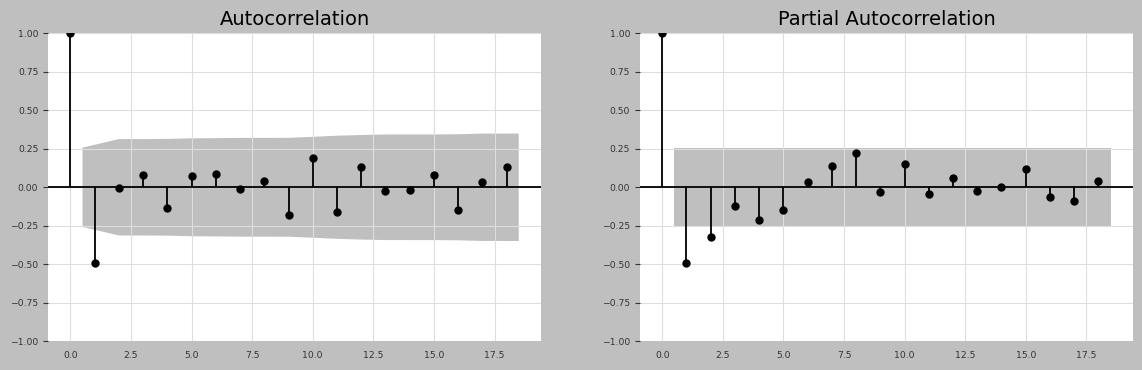

In [70]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]);
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)

In [71]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

np.int64(24)

In [72]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Thu, 04 Dec 2025   AIC                             52.321
Time:                        12:55:25   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# Extract standardized residuals
standardized_residuals = results.filter_results.standardized_forecasts_error[0]

# Perform Ljung-Box test on standardized residuals
ljungbox_results = acorr_ljungbox(standardized_residuals, lags=25, return_df=True)
print(ljungbox_results)

# Count significant p-values (<0.05)
significant_lags = (ljungbox_results['lb_pvalue'] < 0.05).sum()
print(f"Number of significant lags: {significant_lags}")

      lb_stat  lb_pvalue
1   13.433225   0.000247
2   13.433315   0.001211
3   13.945341   0.002981
4   16.387314   0.002541
5   17.461674   0.003703
6   17.540950   0.007488
7   17.547304   0.014188
8   18.083407   0.020610
9   21.436042   0.010849
10  22.965112   0.010876
11  23.057215   0.017350
12  23.059015   0.027229
13  23.474105   0.036327
14  24.472572   0.040146
15  25.848393   0.039647
16  27.477958   0.036467
17  27.478215   0.051417
18  30.761281   0.030671
19  36.785658   0.008439
20  40.353270   0.004506
21  41.308961   0.005134
22  41.570702   0.007043
23  45.654603   0.003301
24  49.217935   0.001778
25  49.428241   0.002505
Number of significant lags: 24


In [74]:
(acorr_ljungbox(standardized_residuals, 
                lags=25,
                return_df=True))['lb_pvalue']

1     0.000247
2     0.001211
3     0.002981
4     0.002541
5     0.003703
6     0.007488
7     0.014188
8     0.020610
9     0.010849
10    0.010876
11    0.017350
12    0.027229
13    0.036327
14    0.040146
15    0.039647
16    0.036467
17    0.051417
18    0.030671
19    0.008439
20    0.004506
21    0.005134
22    0.007043
23    0.003301
24    0.001778
25    0.002505
Name: lb_pvalue, dtype: float64

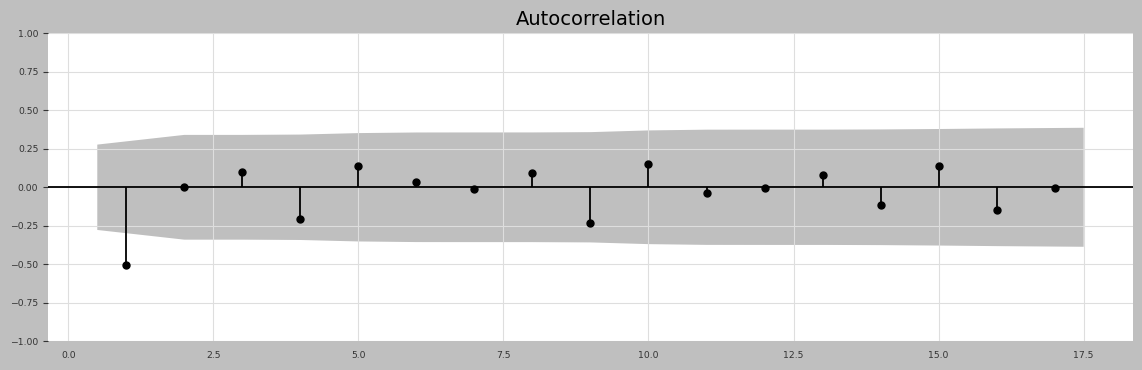

In [75]:
plot_acf(standardized_residuals, zero=False);

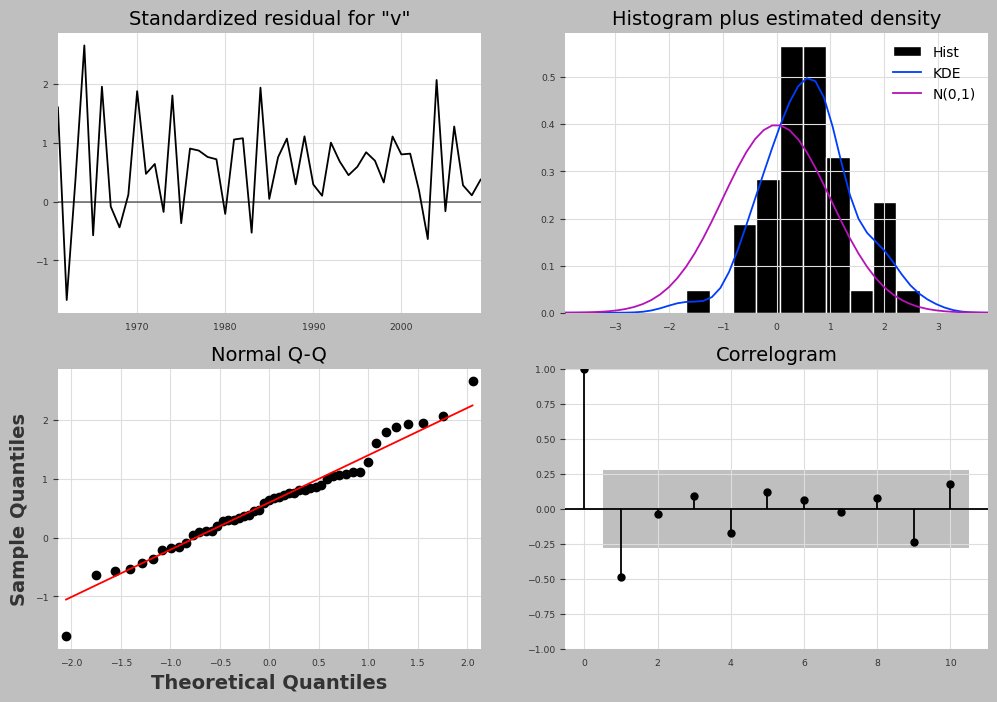

In [76]:
results.plot_diagnostics(figsize=(12,8));

In [77]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

np.int64(0)

In [78]:
from scipy.stats import shapiro
shapiro(standardized_residuals)[1] < 0.05

np.False_

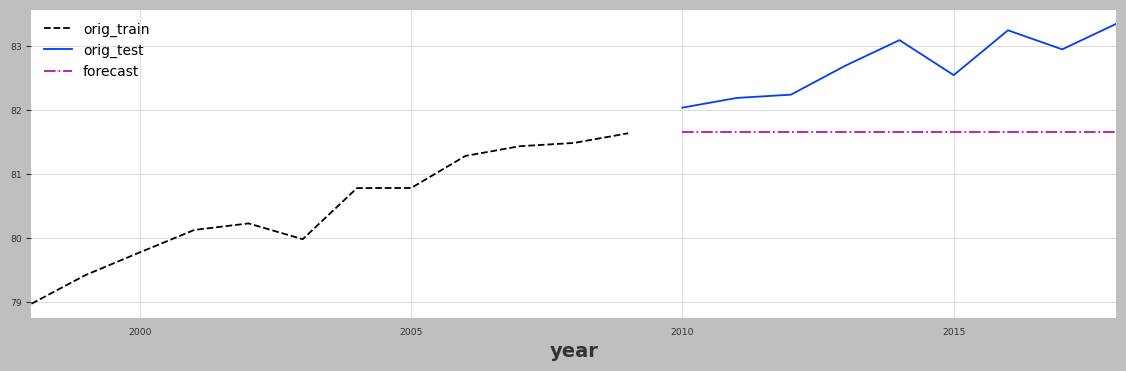

In [79]:
plot_forecast(results, '1998', life_train, life_test);

## There is more

In [80]:
# Create lists [0,1,2] for p, d, and q
pv, dv, qv = [list(range(3))]*3
# Generate all possible combinations
vals = combinator([pv, dv, qv ])

# Initialize a dictionary to store results
score = {}

# Train multiple ARIMA models
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_train.values.ravel() 
    y_hat = res.forecast(steps=len(y))
 # Store multiple performance metrics for comparison
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Sec

In [81]:
top_5_models = get_top_models_df(score, 'AIC')
top_5_models

,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
model_id,,,,,,,,
8,"(0, 2, 2)",7.697707,1.654410,13.311310,8.243162,12.370909,0.164673,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",9.533199,1.638446,17.100481,10.442290,12.239986,0.162932,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
17,"(1, 2, 2)",9.675660,1.653313,17.160464,10.605893,12.362193,0.164557,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
26,"(2, 2, 2)",10.671686,1.663602,20.027691,12.100257,12.444132,0.165643,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",11.510115,1.636793,20.969217,12.905464,12.226714,0.162755,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [82]:
best_m = top_5_models.iloc[0,-1]
best_m

In [83]:
#  you can always change the top_n and criterion and shown
get_top_models_df(score, 'MAPE', top_n=27)

,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
model_id,,,,,,,,
0,"(0, 0, 0)",280.675284,0.513646,284.499330,280.930604,3.849004,0.044679,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,"(0, 0, 1)",223.397152,0.528572,229.133221,223.918892,3.944335,0.045394,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,"(0, 0, 2)",179.009817,0.550590,186.657909,179.898706,4.089434,0.046372,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
11,"(1, 0, 2)",57.760866,0.988372,67.320981,59.124502,7.083867,0.080812,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
20,"(2, 0, 2)",66.439356,0.990401,77.911494,68.392844,7.098810,0.081031,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
18,"(2, 0, 0)",62.380172,0.991954,70.028264,63.269061,7.111423,0.081330,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
10,"(1, 0, 1)",62.740976,0.993925,70.389068,63.629864,7.127122,0.081663,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,"(1, 0, 0)",61.262602,0.995819,66.998671,61.784341,7.142305,0.081985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
19,"(2, 0, 1)",65.262585,0.996041,74.822700,66.626222,7.144015,0.082016,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [84]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Thu, 04 Dec 2025   AIC                              7.698
Time:                        12:55:27   BIC                             13.311
Sample:                    01-01-1960   HQIC                             9.819
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9463      9.018     -0.216      0.829     -19.621      15.728
ma.L2          0.9986      9.247      0.108      0.914     -17.125      19.122
sigma2         0.0499      0.464      0.108      0.914      -0.859       0.959
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

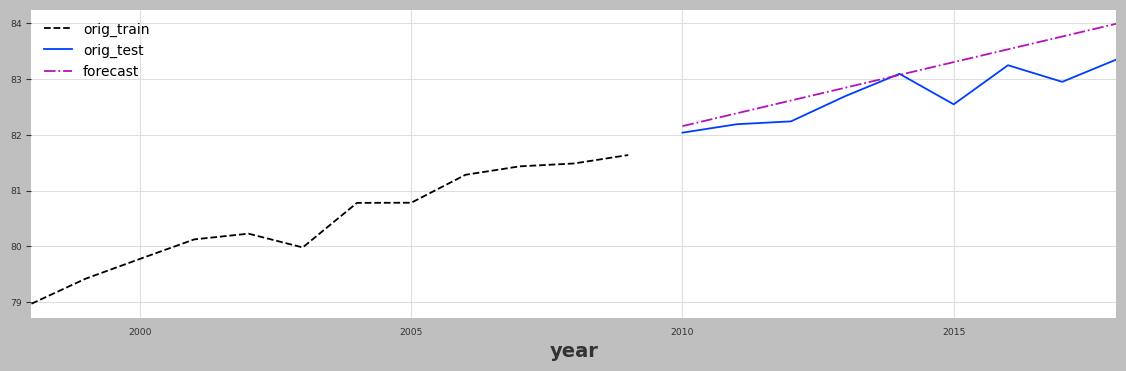

In [85]:
plot_forecast(best_m, '1998', life_train, life_test);

In [86]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Thu, 04 Dec 2025   AIC                              7.698
Time:                        12:55:27   BIC                             13.311
Sample:                    01-01-1960   HQIC                             9.819
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9463      9.018     -0.216      0.829     -19.621      15.728
ma.L2          0.9986      9.247      0.108      0.914     -17.125      19.122
sigma2         0.0499      0.464      0.108      0.914      -0.859       0.959
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

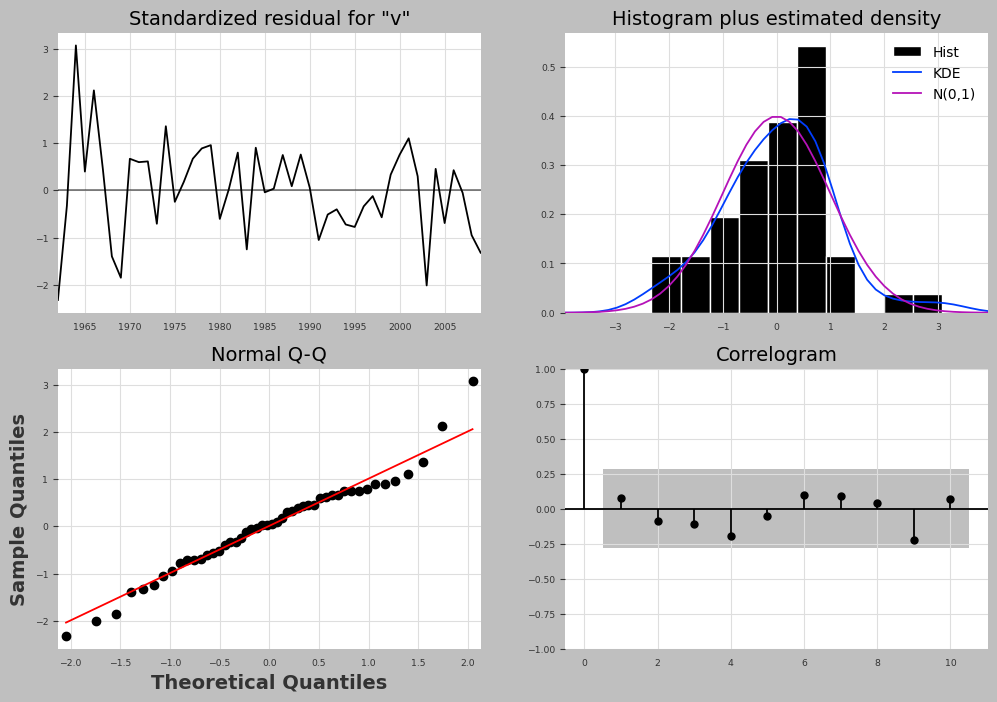

In [87]:
best_m.plot_diagnostics(figsize=(12,8));

In [88]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(milk_train, order=(p,d,q))
    res = m.fit()
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

In [89]:
milk_top_models = get_top_models_df(score, 'AIC')
milk_top_models

,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,
26,"(2, 2, 2)",1445.411301,1460.155100,1445.855745,1.130944,103.395758,0.097156,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",1458.932327,1473.711462,1459.373503,1.052131,96.733984,0.086554,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(0, 1, 2)",1466.122925,1474.990406,1466.296838,1.271762,115.822624,0.112387,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",1466.878216,1478.701525,1467.170187,1.234587,112.601237,0.108002,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
11,"(1, 0, 2)",1467.165995,1481.980218,1467.603951,1.457496,131.857306,0.133059,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [90]:
milk_best_model = milk_top_models.iloc[0,-1]

milk_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  143
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -717.706
Date:                Thu, 04 Dec 2025   AIC                           1445.411
Time:                        12:55:28   BIC                           1460.155
Sample:                    01-01-1962   HQIC                          1451.403
                         - 11-01-1973                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7321      0.004   -400.866      0.000      -1.741      -1.724
ar.L2         -0.9995      0.002   -448.265      0.000      -1.004      -0.995
ma.L1          1.7117      1.629      1.051      0.293      -1.481       4.904
ma.L2          0.9992      1.896      0.527      0.598      -2.716       4.715
sigma2      1446.0807   2671.300      0.541      0.588   -3789.571    6681.733
===================================================================================
Ljung-Box (L1) (Q):                   3.55   Jarque-Bera (JB):                10.57
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):               1.27   Skew:                             0.67
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

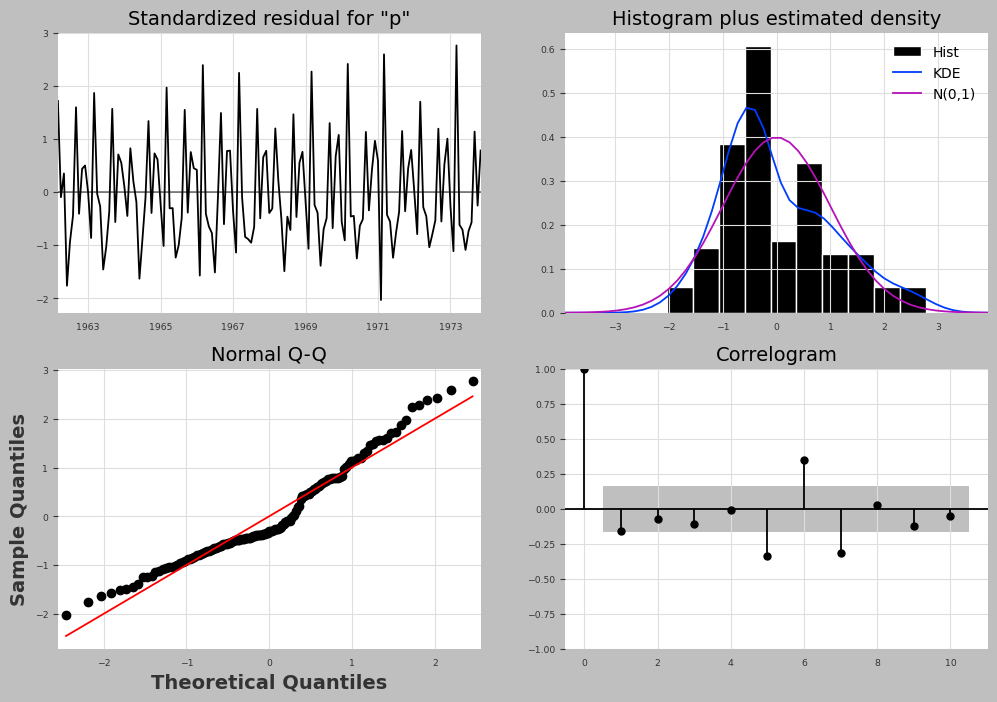

In [91]:
milk_best_model.plot_diagnostics(figsize=(12,8));

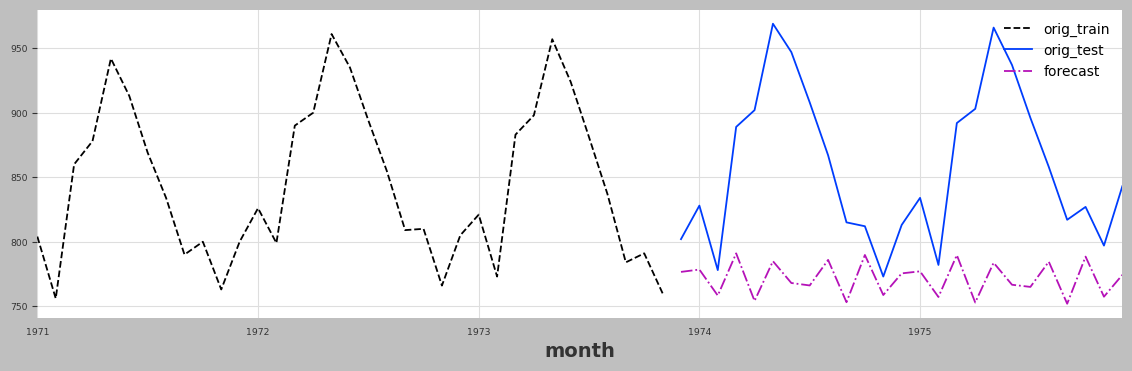

In [92]:
plot_forecast(milk_best_model, '1971', milk_train, milk_test);

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

<Axes: xlabel='month'>

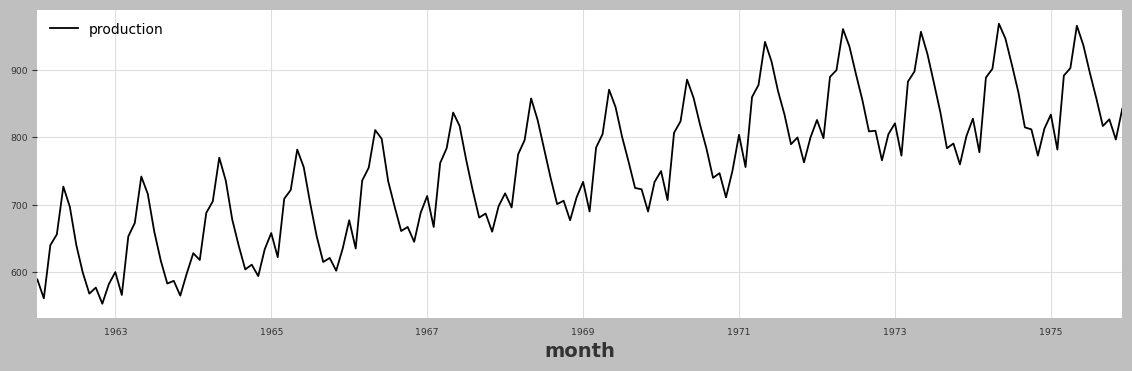

In [94]:
milk.plot()

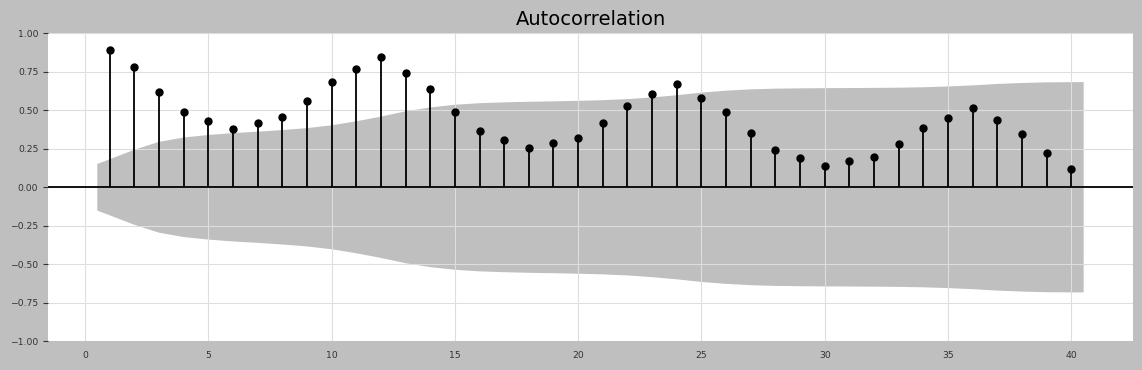

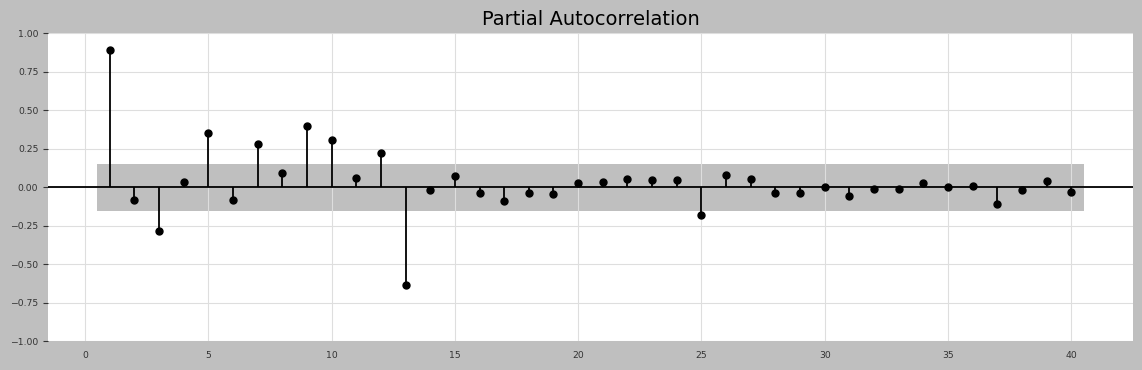

In [95]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);

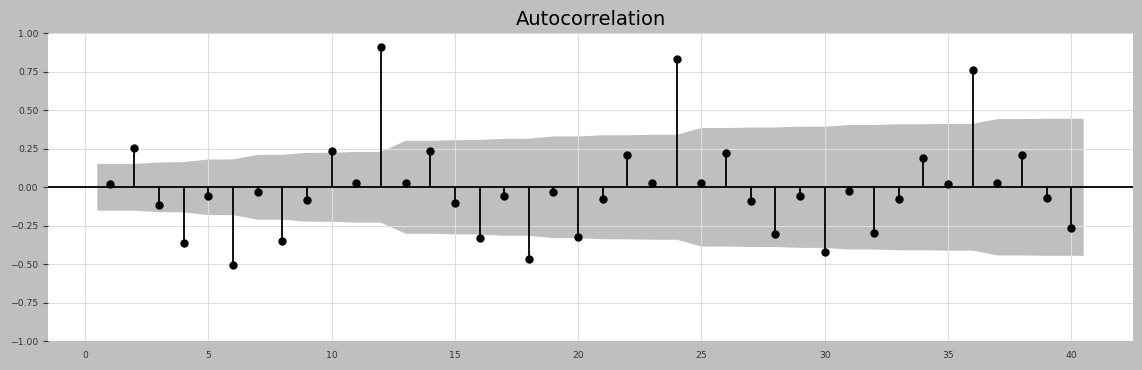

In [96]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); 

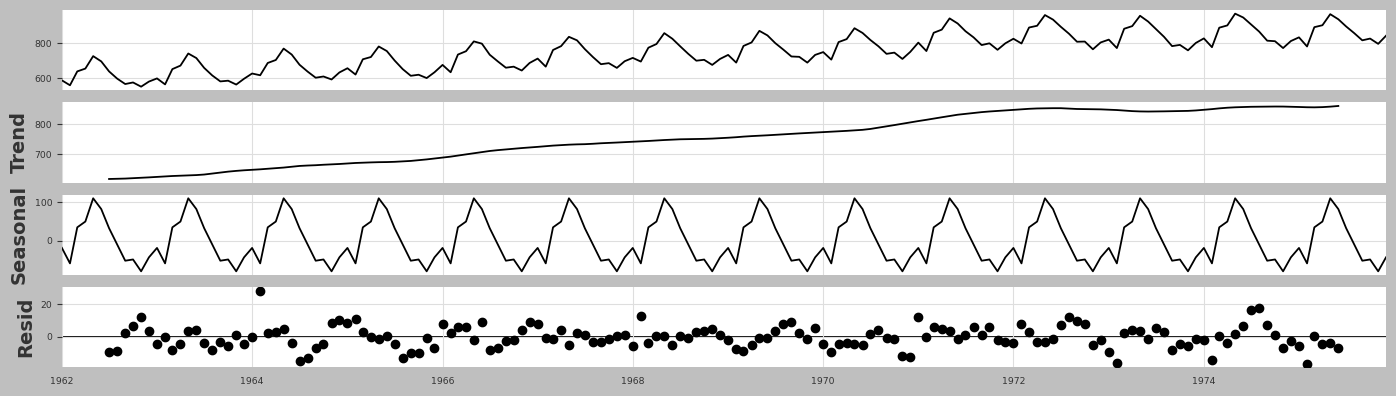

In [97]:
decomposed = seasonal_decompose(milk, 
                                period=12, 
                                model='additive')
decomposed.plot(); 

In [98]:
milk_s = decomposed.seasonal

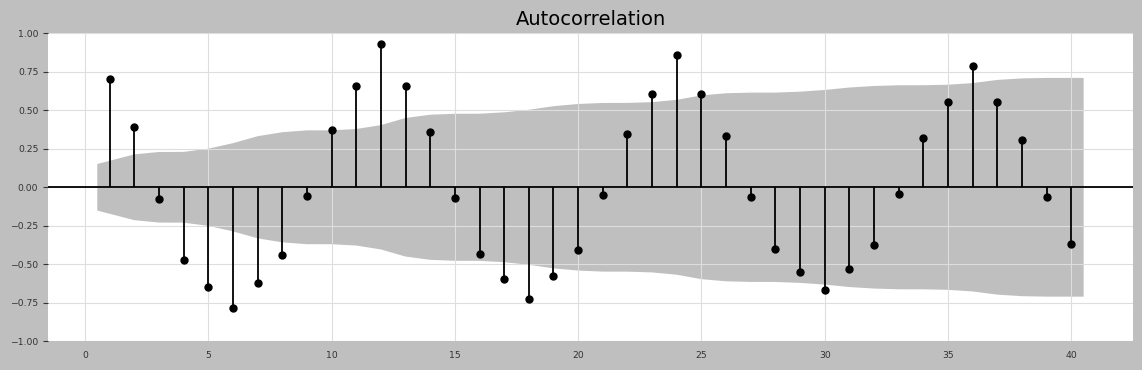

In [99]:
plot_acf(milk_s, zero=False, lags=40);

In [100]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.6274267086030334 	 lags:13
'Non-Stationary	 p-value:0.16079880527711304 	 lags:12
'Stationary	 p-value:1.8654234318789037e-05 	 lags:11


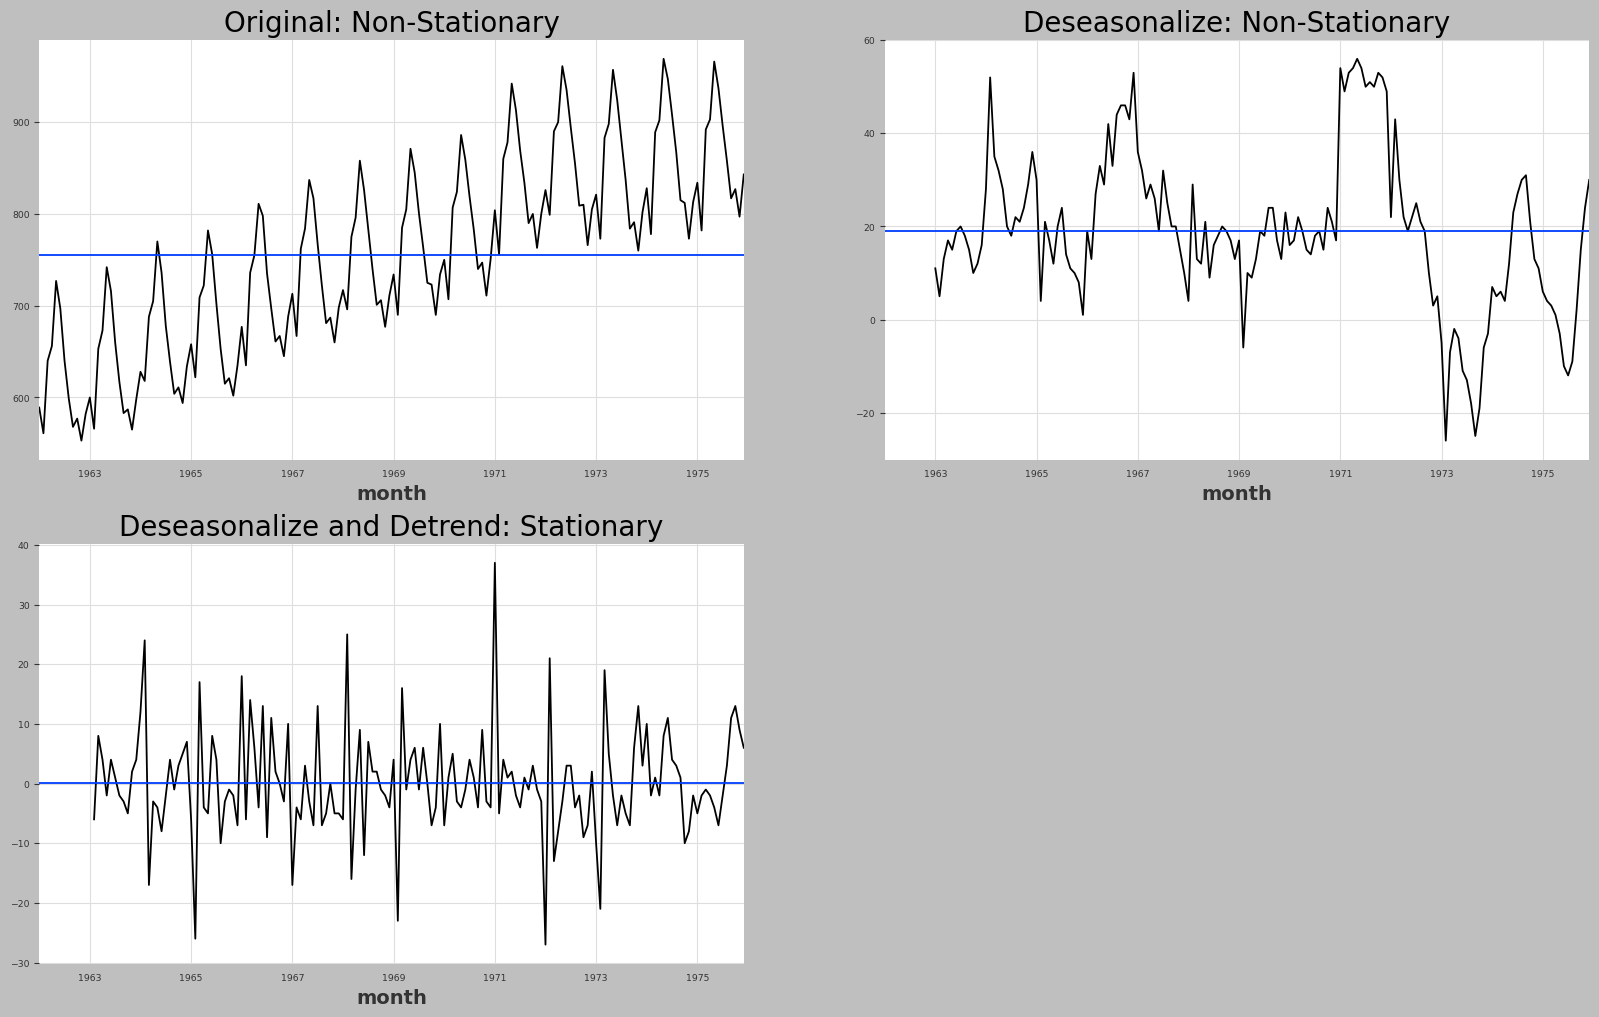

In [101]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

### How to Determine AR and MA terms

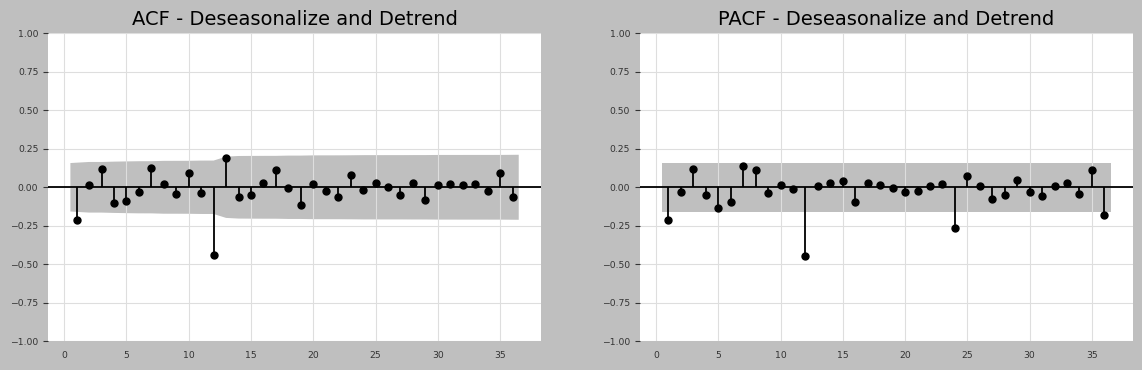

In [102]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, 
         zero=False, 
         lags=36, 
         ax=ax[0], 
         title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, 
          zero=False, 
          lags=36, 
          ax=ax[1], 
          title=f'PACF - {d_desc}');

[1, 12, 24, 36, 48]


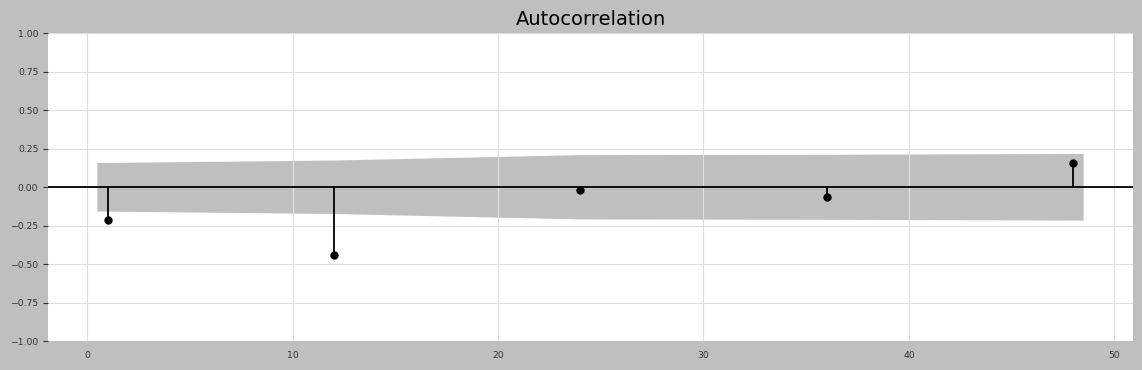

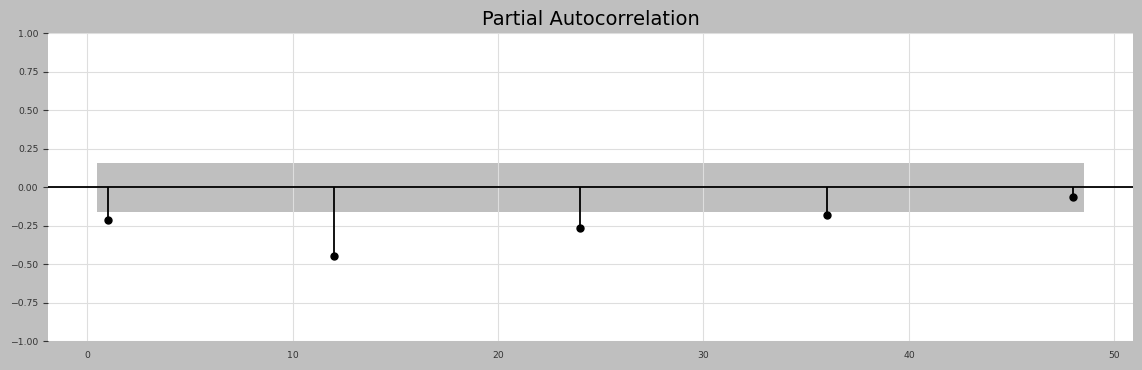

In [103]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

### Fitting a SARIMA Model

In [104]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


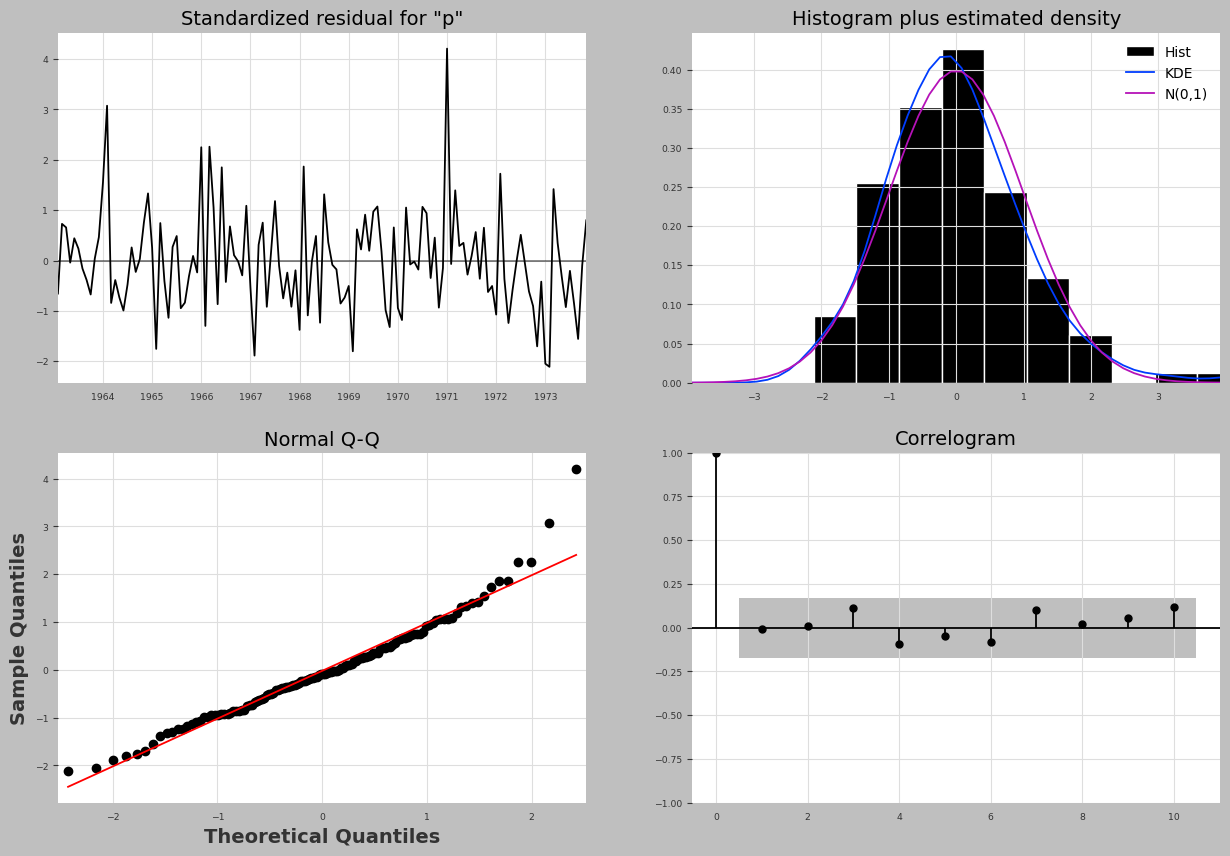

In [105]:
model.plot_diagnostics(figsize=(15,10));
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)

In [106]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 04 Dec 2025   AIC                            903.335
Time:                                    12:55:31   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

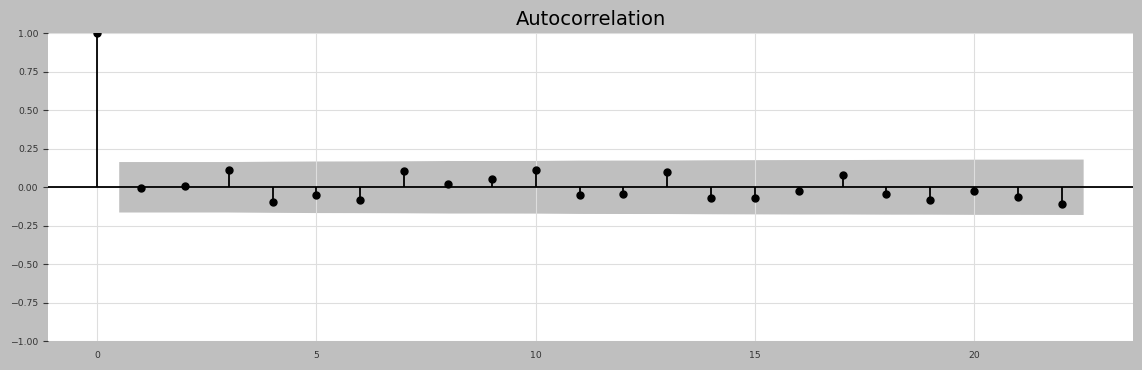

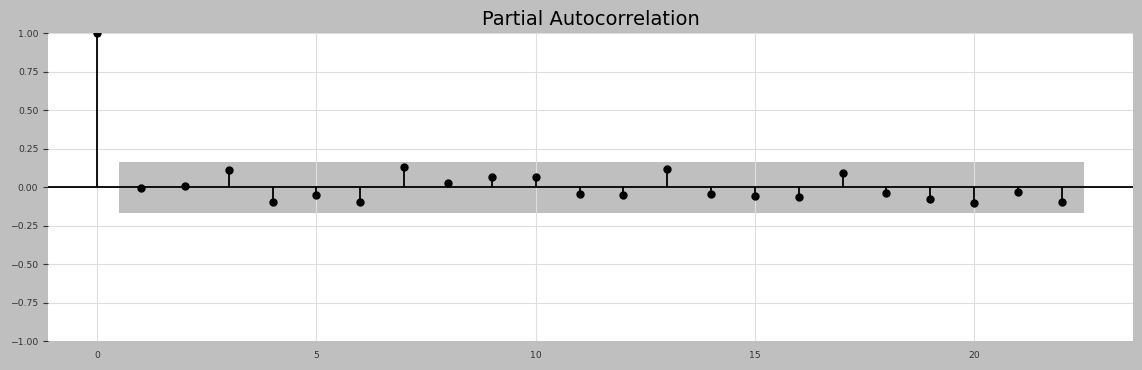

In [107]:
standardized_resid = model.filter_results.standardized_forecasts_error[0]
plot_acf(standardized_resid);
plot_pacf(standardized_resid); 

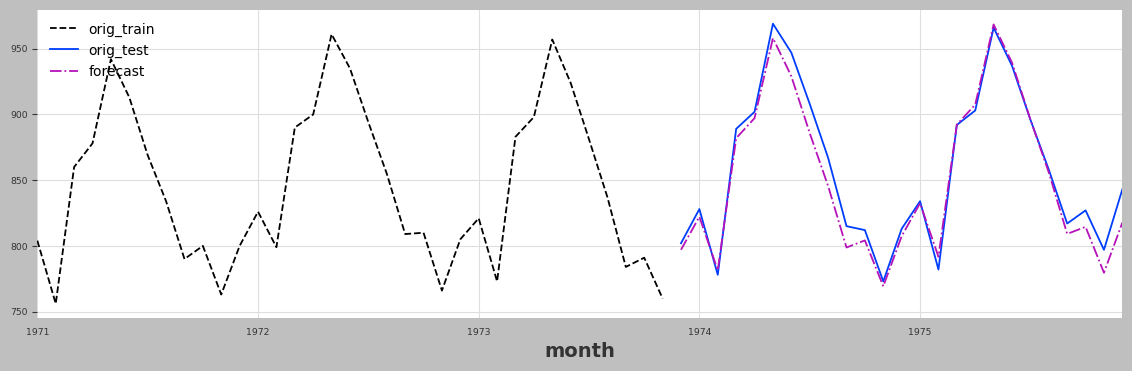

In [108]:
plot_forecast(model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

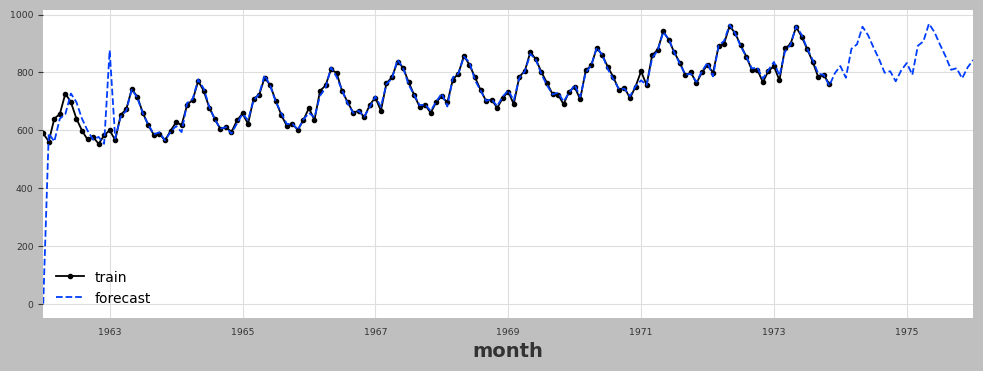

In [109]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

## There is more

In [110]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #15 using SARIMA(0,0,1)(1,1,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #30 using SARIMA(0,1,0)(1,1,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #45 using SARIMA(0,1,2)(1,0,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #60 using SARIMA(0,2,1)(1,0,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #75 using SARIMA(1,0,0)(0,1,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #90 using SARIMA(1,0,2)(0,1,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #105 using SARIMA(1,1,1)(0,0,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #120 using SARIMA(1,2,0)(0,0,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #135 using SARIMA(1,2,1)(1,1,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #150 using SARIMA(2,0,0)(1,1,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #165 using SARIMA(2,0,2)(1,0,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #180 using SARIMA(2,1,1)(1,0,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookb

Running model #195 using SARIMA(2,2,0)(0,1,1,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

Running model #210 using SARIMA(2,2,2)(0,1,0,12)


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/

CPU times: user 28.8 s, sys: 784 ms, total: 29.6 s
Wall time: 39.3 s


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch10/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
3*3*3*2*2*2

216

In [112]:
get_top_models_df(score, 'AIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328240,27.797214,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.128260,10.998611,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.798080,0.289726,24.535286,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [113]:
get_top_models_df(score, 'BIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328240,27.797214,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.134090,11.489677,0.010370,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.798080,0.289726,24.535286,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [114]:
best_model = get_top_models_df(score, 'BIC').iloc[0,-1]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  143
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -393.758
Date:                              Thu, 04 Dec 2025   AIC                            795.516
Time:                                      12:56:11   BIC                            806.461
Sample:                                  01-01-1962   HQIC                           799.958
                                       - 11-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2806      0.096    -13.353      0.000      -1.469      -1.093
ma.L2          0.3054      0.107      2.860      0.004       0.096       0.515
ma.S.L12      -0.6217      0.082     -7.556      0.000      -0.783      -0.460
sigma2        56.9487      6.214      9.165      0.000      44.769      69.128
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                28.17
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.76
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

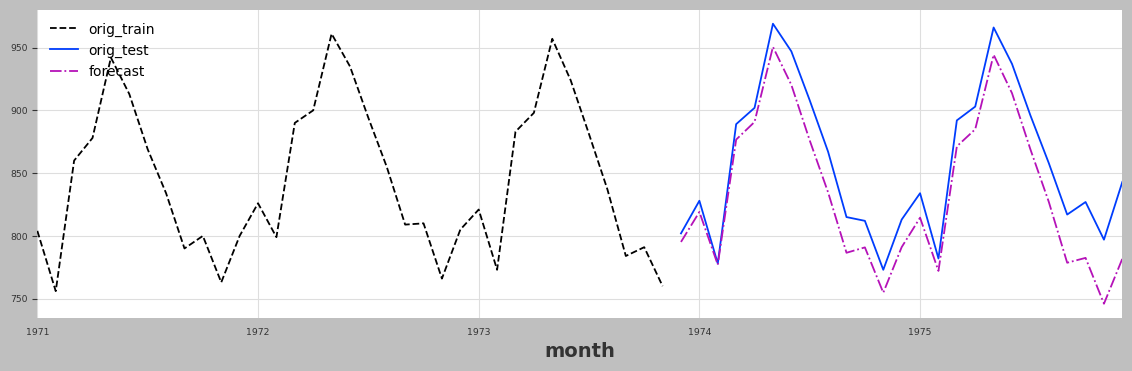

In [115]:
plot_forecast(best_model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)

# Recipe 5: Forecasting Time Series Data using Auto_ARIMA

You will need to install pmdarima before you can proceed with this recipe. 

* To install it using `pip`, use the following command:

```
pip install pmdarima
```

* To install it using `conda`, use the following command:
```
conda install -c conda-forge pmdarima

In [118]:
!uv pip install numpy==1.26.4

Resolved 1 package in 573ms                                          
Prepared 1 package in 4.97s                                              
Uninstalled 1 package in 107ms
Installed 1 package in 23ms                                 
 - numpy==2.3.3
 + numpy==1.26.4


In [11]:
# if you are using the same Python venv then you will need to downgrade numpy
# An alternate option is to create a seperate venv for this recipe 

# !pip install numpy==1.26.4  
import numpy as np
import matplotlib.pyplot as plt
np.__version__

'1.26.4'

In [12]:
import pmdarima as pm

In [13]:
pm.__version__

'2.0.4'

In [14]:
milk_train.shape

(143, 1)

In [15]:
milk_test.shape

(25, 1)

In [16]:
milk_train.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [17]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf',
                           stepwise=True)

In [18]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 04 Dec 2025   AIC                            903.335
Time:                                    12:57:58   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=908.834, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=951.320, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=917.481, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=903.335, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=940.547, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=905.280, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=905.265, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=917.295, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=911.816, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=905.240, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=905.159, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=903.959, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=907.070, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [20]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='bic',
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=928.907, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=954.187, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=926.083, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=911.938, Time=0.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=946.282, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=916.750, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=916.735, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=925.897, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=917.551, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=916.710, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : BIC=916.630, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=912.562, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : BIC=921.407, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [21]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 04 Dec 2025   AIC                            903.335
Time:                                    12:58:07   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

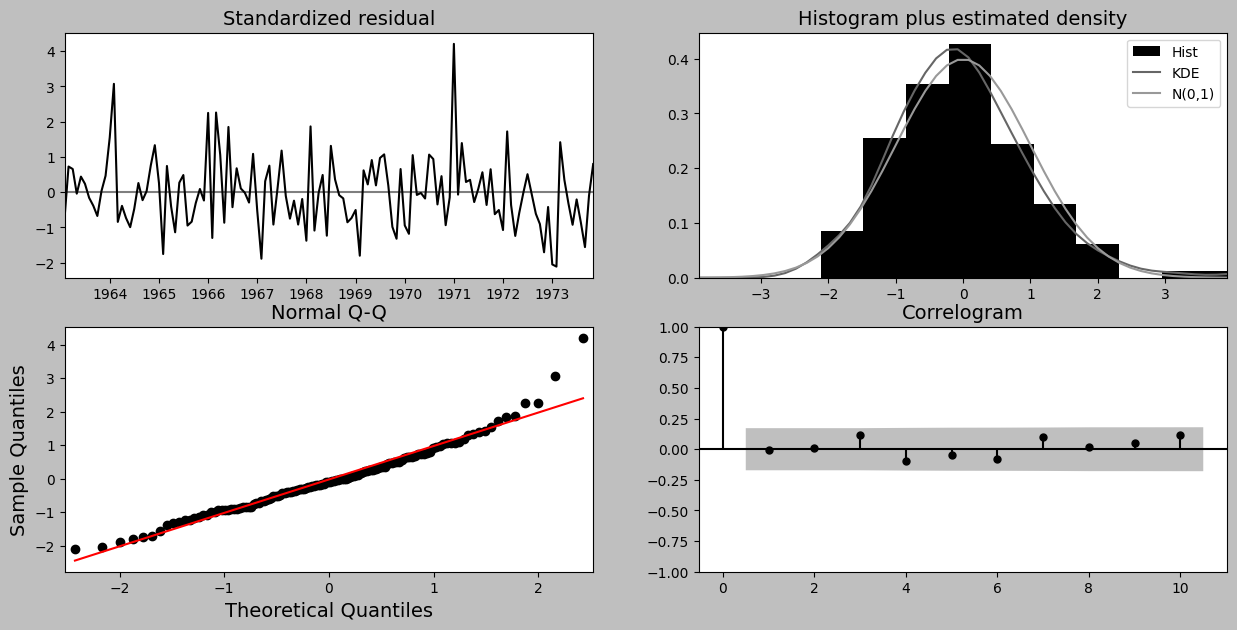

In [22]:
auto_model.plot_diagnostics(figsize=(15,7));

In [23]:
auto_model.scoring

'mse'

In [24]:
auto_model

,order,"(0, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,False


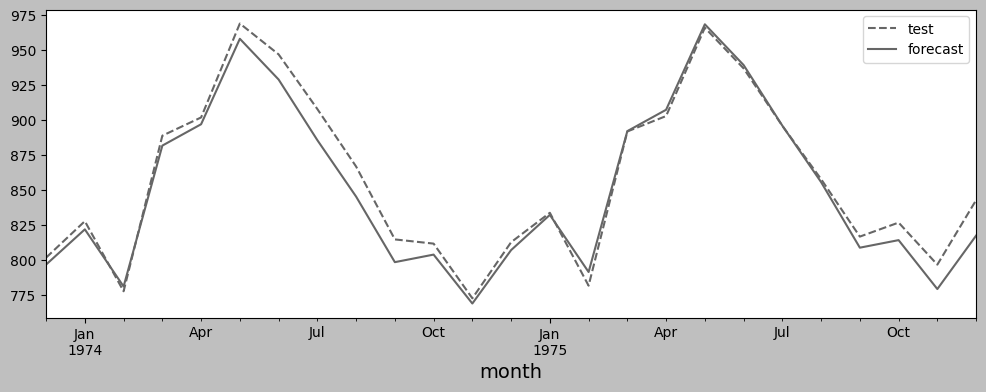

In [25]:
n = milk_test.shape[0]
index = milk_test.index
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(auto_model.predict(n_periods=n), 
          index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show()

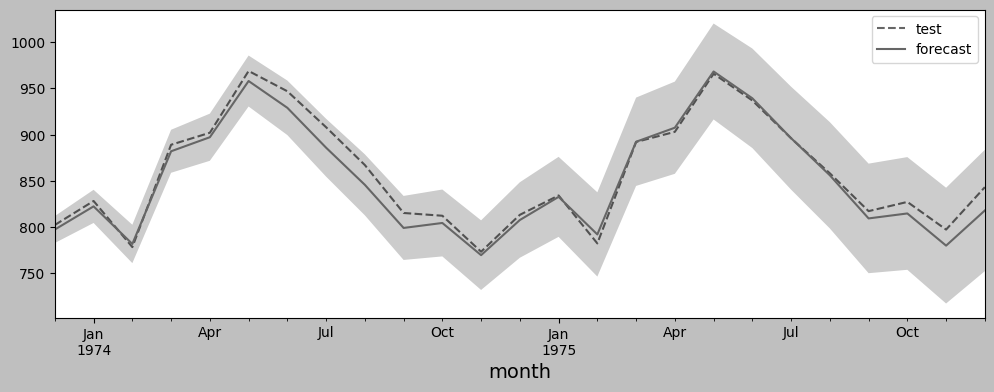

In [26]:
n = milk_test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, 
                                             return_conf_int=True,
                                             alpha=0.05)
lower_ci, upper_ci  = zip(*conf_interval)

index = milk_test.index
# Create plot
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']);


In [27]:
mean_ci = conf_interval.mean(axis=1)
np.array_equal(np.round(forecast, 4), np.round(mean_ci, 4))

True


## There is more

In [28]:
from pmdarima.arima.utils import ndiffs, nsdiffs

# # Augmented Dickey-Fuller test
n_adf = ndiffs(milk, test='adf') 
# KPSS test (auto_arima default):
n_kpss = ndiffs(milk, test='kpss') 
# Phillips-Perron test
n_pp = ndiffs(milk, test='pp')  

In [29]:
print(f'''
differencing (d) term using:
    ADF: {n_adf}
    KPSS: {n_kpss}
    PP: {n_pp}
''')


differencing (d) term using:
    ADF: 0
    KPSS: 1
    PP: 0



In [30]:
# Osborn-Chui-Smith-Birchenhall test
n_ocsb = nsdiffs(milk, test='ch', m=12) 
# Canova-Hansen test
n_ch = nsdiffs(milk, test='ocsb',m=12) 


In [31]:
print(f'''
Seasonal differencing (D) term: 
    OCSB: {n_ocsb}
    CH: {n_ch}
''')


Seasonal differencing (D) term: 
    OCSB: 0
    CH: 1



In [32]:
model = pm.auto_arima(milk_train, 
                      seasonal=True,
                      with_intercept=True,
                      # Non-seasonal parameters
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      # Seasonal parameters
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      # Search settings
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=25,
                      test = 'kpss',
                      score='mape',
                      trace=True)                      


 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=953.294, Time=0.02 sec


 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=913.693, Time=0.24 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=915.576, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=928.929, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=915.603, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=921.521, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=916.806, Time=0.37 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=942.458, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=905.043, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=906.971, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=919.027, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=906.985, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,1,1)(2,1,0)[12] intercept   : AIC=912.298, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[1

In [33]:
model.out_of_sample_size

0

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -446.284
Date:                            Thu, 04 Dec 2025   AIC                            904.567
Time:                                    12:58:41   BIC                            921.773
Sample:                                01-01-1962   HQIC                           911.558
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2781      0.655     -0.424      0.671      -1.563       1.006
ar.L1         -1.2086      0.091    -13.352      0.000      -1.386      -1.031
ar.L2         -0.3154      0.103     -3.072      0.002      -0.517      -0.114
ma.L1          0.9691      0.054     17.793      0.000       0.862       1.076
ma.S.L12      -0.6235      0.087     -7.142      0.000      -0.795      -0.452
sigma2        52.9649      5.742      9.225      0.000      41.711      64.218
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                49.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.92
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

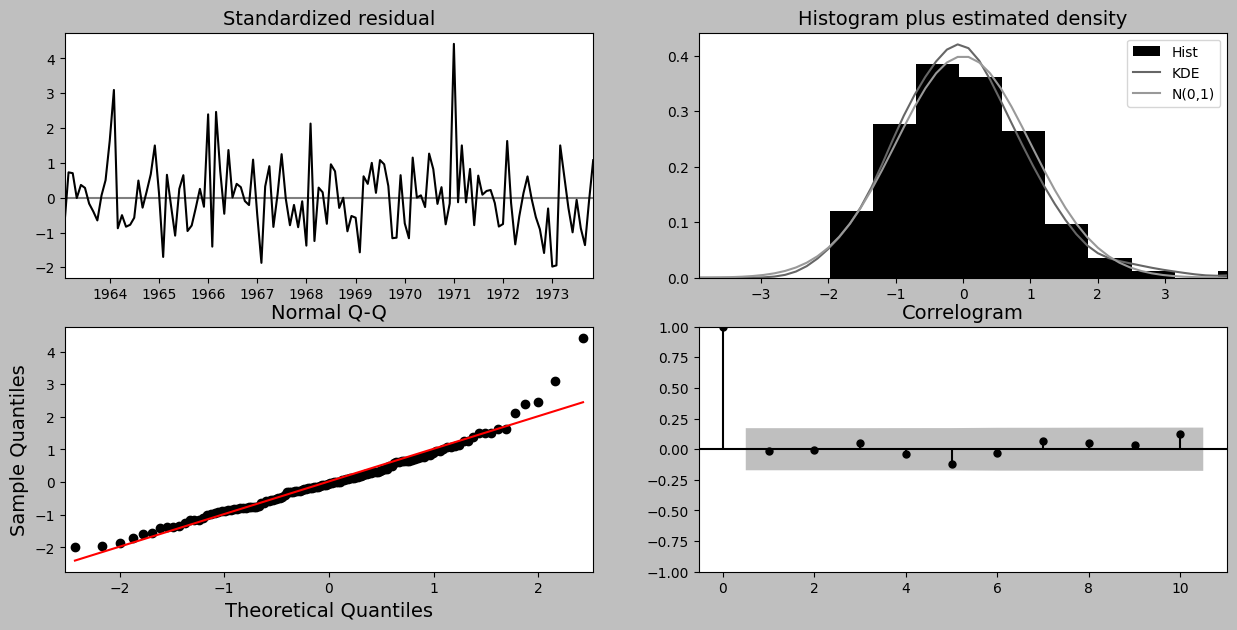

In [35]:
model.plot_diagnostics(figsize=(15,7));

In [36]:
from darts.models import AutoARIMA
from darts import TimeSeries

The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


### Using Darts AutoARIMA

In [37]:
ts = TimeSeries.from_dataframe(milk_train.reset_index(), 
                                    time_col='month', 
                                    value_cols='production', 
                                    freq='MS')

In [38]:
model = AutoARIMA(season_length=12)
model.fit(ts)
pred = model.predict(len(milk_test))

In [39]:
model.model.model_.keys()

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'xreg', 'bic', 'aicc', 'ic', 'x', 'lambda'])

In [40]:
model.model.model_.get('arma')

(1, 1, 0, 1, 12, 0, 1)

In [41]:
pred.values()

array([[800.28453919],
       [827.4772704 ],
       [788.64452067],
       [890.87039517],
       [907.74954615],
       [970.22681412],
       [942.58619764],
       [900.60338338],
       [861.55757857],
       [815.92439141],
       [822.33514468],
       [788.40552424],
       [828.57521783],
       [855.27706743],
       [815.98985623],
       [917.79498728],
       [934.28461115],
       [996.40125232],
       [968.42676514],
       [926.13485116],
       [886.80287975],
       [840.90475765],
       [847.07023238],
       [812.91353143],
       [852.87299236]])

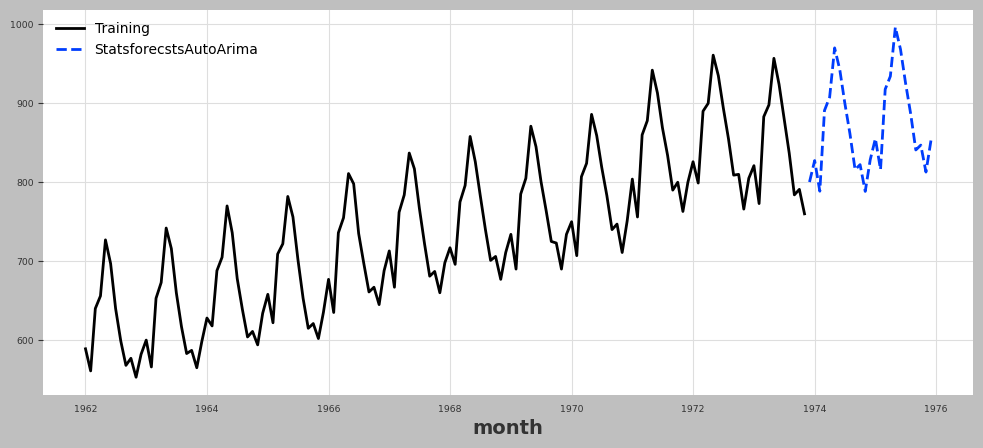

In [42]:
ts.plot(label='Training')
pred.plot(label='StatsforecstsAutoArima', linestyle='--');